# Readmition predictor project - EDA
data: The Diabetes 130-US Hospitals for Years 1999 – 2008 from the UC Irvine ML Repository:
https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-200


## Predict the 30-day readmission rates for patients diagnosed with diabetes upon admission.
weusedgtthis article as our starting point for the data manipulation :
https://www.hindawi.com/journals/bmri/2014/781670/

# Working with data_transformer pipeline

In [258]:
import data_transformers as dt
import importlib
from sklearn.pipeline import Pipeline
importlib.reload(dt)

<module 'data_transformers' from 'C:\\Users\\dekel\\Desktop\\Tidy Data-20240116\\ml-2024\\data_transformers.py'>

In [241]:
numerical_fetures = ['time_in_hospital',
                   'num_lab_procedures',
                   'num_procedures',
                   'num_medications',
                  'number_outpatient',
                  'number_emergency',
                  'number_inpatient',
                  'number_diagnoses']

df_categorical = df.drop(columns=numerical_columns+['patient_nbr'])
cat_fetures = df_categorical.drop(columns=['readmitted']).keys()

replace_?_to_nan = dt.ReplaceValueToNan(value='?')
df = replace_value_to_nan.transform(df)

In [259]:
full_pipeline = Pipeline([
    ('change_nan_values', dt.ReplaceValueToNan(value='?'))
    ])

In [ ]:
full_pipeline

In [249]:
# here I put the full pipe line that I use

df.replace('?', np.nan, inplace=True)

def drop_missing_features(df, columns_to_drop=['weight', 'payer_code'], columns_nan_to_missing = ['race', 'medical_specialty']):
    try:
        df.drop(columns=columns_to_drop, inplace=True)
    except KeyError:
        ''
    for column in columns_nan_to_missing:
        df.loc[~df[column].notna(), column] = 'missing'
    return df
    
df = drop_missing_features(df)

def drop_death_and_hospice(df, drop_discharge_disposition_ids=[11,13,14,19,20,21]):
    '''remove death or hospise cases from the data '''
    return df.loc[~df.discharge_disposition_id.isin(drop_discharge_disposition_ids)]
    
df = drop_death_and_hospice(df)


def fix_readmitted_values(df):
    ''' we defined the readmission attribute (outcome) as having two values: “readmitted,” if the patient was readmitted within 30 days of discharge or “otherwise”'''
    df.loc[df.readmitted == '<30', 'readmitted'] = 'readmitted'
    df.loc[df.readmitted != 'readmitted', 'readmitted'] = 'otherwise'
    return df
    
df = fix_readmitted_values(df)


numerical_columns = ['time_in_hospital',
                   'num_lab_procedures',
                   'num_procedures',
                   'num_medications',
                  'number_outpatient',
                  'number_emergency',
                  'number_inpatient',
                  'number_diagnoses']
# categorical
df_categorical = df.drop(columns=numerical_columns+['patient_nbr'])
# df_categorical.drop(columns=['patient_nbr'], inplace=True)

# Remove features with zero variance and perhaps also those with small variance
def fraction_of_unique_values(df, column):
    '''gets the fraction and counts for each column in a df, based on df.nunique function'''
    try:
        unique_values, counts = np.unique(df[column], return_counts=True)
    except TypeError:
        unique_values, counts = np.unique(df[column].astype(str), return_counts=True)
        
    fraction = 100 * (counts / sum(counts))
    
    return np.sort(fraction)[::-1], np.sort(counts)[::-1]

def is_one_of_the_values_have_bigger_fraction_then(fraction, threshold=95):
    '''cheack if a value in a list is bigger of threshold, return bool'''
    return (fraction > threshold).any()


def remove_features_with_low_variance(df, threshold=95):
    column_unique_counts = pd.DataFrame(df.nunique().sort_values(), columns=['unique']).reset_index()
    column_unique_counts.rename(columns={'index': 'column'}, inplace=True)
    column_unique_counts[['fraction_of_unique_values', 'counts']] = pd.DataFrame(column_unique_counts['column'].apply(lambda col: fraction_of_unique_values(df, col)).apply(pd.Series))
    coloumn_with_bed_value_destribution = column_unique_counts.apply(lambda row: is_one_of_the_values_have_bigger_fraction_then(row.fraction_of_unique_values, threshold), axis=1)
    coloumns_to_remove = column_unique_counts[coloumn_with_bed_value_destribution].column.values
    return df.drop(columns=coloumns_to_remove)
    
df_categorical = remove_features_with_low_variance(df_categorical)


def modify_feature_indexs(df, column, value_to_remove='Unknown/Invalid'):
    '''returns a list of indexes based on column and value'''
    index_to_drop = df[(df.gender == 'Unknown/Invalid')].index
    return index_to_drop
    
column = 'gender';  value_to_remove='Unknown/Invalid'
indexs_of_gender_to_drop = modify_feature_indexs(df_categorical, column, value_to_remove=value_to_remove)

df.drop(index=indexs_of_gender_to_drop, inplace=True)
df_categorical.drop(index=indexs_of_gender_to_drop, inplace=True)


def group_cat_column_by_dict(df, column, group_dict):
    '''group multiple values inside a feature using dict: {new_value: [list_of_old_values]}
    all values that are not defined in the group_deict will return as other '''
    for key in group_dict.keys():
        df.loc[df[column].isin(group_dict[key]), column] = key
    if not 'other' in group_dict:
        df.loc[~df[column].isin(group_dict.keys()), column] = 'other'
    df[column].replace(np.nan, 'missing')
    return df

df_categorical.rename(columns={'discharge_disposition_id': 'discharge'}, inplace=True)
group_dict={'home': [1]}
df_categorical = group_cat_column_by_dict(df_categorical, 'discharge', group_dict=group_dict)
    
group_dict={'other': [5, 6, 8], 'high_prayority': [1, 2], 'clinic_referral': [3, 4, 7]}
df_categorical = group_cat_column_by_dict(df_categorical, 'admission_type_id', group_dict)
df_categorical.rename(columns={'admission_type_id': 'admission'}, inplace=True)

group_dict={'other': ['Other', 'Hispanic', 'Asian']}
df_categorical = group_cat_column_by_dict(df_categorical, 'race', group_dict)

group_dict={'<30': ['[0-10)', '[10-20)', '[20-30)'], '30<60': ['[30-40)', '[40-50)', '[50-60)'], '>60': ['[60-70)', '[70-80)', '[80-90)', '[90-100)']}
df_categorical = group_cat_column_by_dict(df_categorical, 'age', group_dict)


def keep_top_values(df, column, keep_amount=7):
    unique, counts = np.unique(df_categorical[column].astype(str), return_counts=True)
    sorted_indices = np.argsort(counts)[::-1]  # Reverse order to get descending sort indices
    sorted_unique = unique[sorted_indices]
    df.loc[~(df[column].isin(sorted_unique[:7])), column] ='other'
    return df
   
# we will take all 6 top type of specialeties and missing and we are creating new type : 'other'

df_categorical = keep_top_values(df_categorical, 'medical_specialty', keep_amount=7)


def set_encounters(df):
    '''set encounters for each patient based on  A1C and change in medications'''
    df['encounters'] = 'None'
    df.loc[(df.A1Cresult == '>7') | (df.A1Cresult == '>8'), 'encounters'] = '7_No'
    df.loc[((df.A1Cresult == '>7') | (df.A1Cresult == '>8')) & (df.change == 'Ch'), 'encounters'] = '7_Ch'
    df.loc[df.A1Cresult == 'Norm', 'encounters'] = 'Norm'
    df.drop(columns=['A1Cresult', 'change'], inplace=True)
    return df
df_categorical = set_encounters(df_categorical)



def change_value(value): 
    diag_dict = {1: range(0,140), 2: range(140, 240), 3: range(240,280), 4: range(280,290), 5:range(290,320),
            6: range(320, 390), 7: range(390,460), 8: range(460, 520), 9: range(520, 580), 10: range(580,630),
            11: range(630, 680), 12: range(680,710), 13: range(710, 740), 14: range(740, 760), 15: range(760, 780),
            16: range(780, 800), 17: range(800, 1000), 18: 'E', 19:'V'}

    diag_dict = {value: key for key, values_list in diag_dict.items() for value in values_list}

    value = str(value).split('.')[0]
    try:
        return diag_dict[int(value)]
    except ValueError:
        try:
            return diag_dict[str(value[0]).upper()]
        except KeyError:
            return 'missing'


def change_diag_to_type(row):
    diag_1 = change_value(row['diag_1'])
    diag_2 = change_value(row['diag_2'])
    diag_3 = change_value(row['diag_3'])  
    return pd.Series([diag_1, diag_2, diag_3], index=['diag_1', 'diag_2', 'diag_3'])

# Apply the function to each row and create new columns
df_categorical[['diag_1', 'diag_2', 'diag_3']] = df_categorical.apply(change_diag_to_type, axis=1)

df_categorical = df_categorical.astype(str)
df_categorical = df_categorical.astype('category')
result_df = pd.concat([df_categorical, df[numerical_columns]], axis=1)
# result_df.info()


KeyboardInterrupt



# 0. setup

In [250]:
import os
import pandas as pd
import datetime
from os import listdir
from os.path import isfile, join
import glob
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
from tqdm import tqdm
# Force printing all the variables in each cell, not just the last one: 
InteractiveShell.ast_node_interactivity = "all"


# plot count with percent
def plot_categorical_with_percent(data, column, **kwargs):
    total_count = len(data[column])
    ax = sns.countplot(data=data, x=column, order=data[column].value_counts().index, **kwargs)
    plt.title(f'Count Plot for {column}')
    for p in ax.patches:
        percentage = '{:.2f}%'.format(100 * p.get_height() / total_count)
        x = p.get_x() + p.get_width() / 2
        y = p.get_height() + 0.01 * total_count  # Adjust the vertical position of the text
        ax.annotate(percentage, (x, y), ha='center')
    return ax


# 1. read the data 

The dataset covers 10 years (1998-2008) of diabetes patient data gathered from 130 US hospitals having 70,000 distinct patients. Every record was labelled as to whether the patient was readmitted within 30 days, readmitted after 30 days, or not readmitted at all. 

## List of features and their descriptions in the initial dataset (the dataset is also available at the website of Data Mining and Biomedical Informatics Lab at VCU

https://www.hindawi.com/journals/bmri/2014/781670/tab1/


The data contains sorten coloumns that uses ID:

ID list:
admission_type_id	
1	Emergency
2	Urgent
3	Elective
4	Newborn
5	Not Available
6	NULL
7	Trauma Center
8	Not Mapped
	
discharge_dispoescription
1	Discharged to home
2	Discharged/transferred to another short term hospital
3	Discharged/transferred to SNF
4	Discharged/transferred to ICF
5	Discharged/transferred to another type of inpatient care institution
6	Discharged/transferred to home with home health service
7	Left AMA
8	Discharged/transferred to home under care of Home IV provider
9	Admitted as an inpatient to this hospital
10	Neonate discharged to another hospital for neonatal aftercare
11	Expired
12	Still patient or expected to return for outpatient services
13	Hospice / home
14	Hospice / medical facility
15	Discharged/transferred within this institution to Medicare approved swing bed
16	Discharged/transferred/referred another institution for outpatient services
17	Discharged/transferred/referred to this institution for outpatient services
18	NULL
19	Expired at home. Medicaid only, hospice.
20	Expired in a medical facility. Medicaid only, hospice.
21	Expired, place unknown. Medicaid only, hospice.
22	Discharged/transferred to another rehab fac including rehab units of a hospital .
23	Discharged/transferred to a long term care hospital.
24	Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.
25	Not Mapped
26	Unknown/Invalid
30	Discharged/transferred to another Type of Health Care Institution not Defined Elsewhere
27	Discharged/transferred to a federal health care facility.
28	Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital
29	Discharged/transferred to a Critical Access Hospital (CAH).
	
admission_source_id	description
1	 Physician Referral
2	Clinic Referral
3	HMO Referral
4	Transfer from a hospital
5	 Transfer from a Skilled Nursing Facility (SNF)
6	 Transfer from another health care facility
7	 Emergency Room
8	 Court/Law Enforcement
9	 Not Available
10	 Transfer from critial access hospital
11	Normal Delivery
12	 Premature Delivery
13	 Sick Baby
14	 Extramural Birth
15	Not Available
17	NULL
18	 Transfer From Another Home Health Agency
19	Readmission to Same Home Health Agency
20	 Not Mapped
21	Unknown/Invalid
22	 Transfer from hospital inpt/same fac reslt in a sep claim
23	 Born inside this hospital
24	 Born outside this hospital
25	 Transfer from Ambulatory Surgery Center
26	Transfer from Hospice



In [254]:
path_to_data = 'C://Users/dekel//Desktop//python-tutorials-AMLLS-20231218T140422Z-001//python-tutorials-AMLLS//Project//'
df = pd.read_csv(path_to_data + "diabetic_data.csv", index_col = 0)

## 1.1 Take a Quick Look at the Data Structure

In [11]:
df.head()

,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
encounter_id,,,,,,,,,,,,,,,,,,,,,
2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,...,No,No,No,No,No,No,No,No,No,NO
149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,...,No,Up,No,No,No,No,No,Ch,Yes,>30
64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,...,No,No,No,No,No,No,No,No,Yes,NO
500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,...,No,Up,No,No,No,No,No,Ch,Yes,NO
16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


looks like missing values are marked as "?" 
we are changeing it to nan so we could use the df.info() function and see the real non-null count

In [13]:
# Data first glance
df.replace('?', np.nan, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101766 entries, 2278392 to 443867222
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   patient_nbr               101766 non-null  int64 
 1   race                      99493 non-null   object
 2   gender                    101766 non-null  object
 3   age                       101766 non-null  object
 4   weight                    3197 non-null    object
 5   admission_type_id         101766 non-null  int64 
 6   discharge_disposition_id  101766 non-null  int64 
 7   admission_source_id       101766 non-null  int64 
 8   time_in_hospital          101766 non-null  int64 
 9   payer_code                61510 non-null   object
 10  medical_specialty         51817 non-null   object
 11  num_lab_procedures        101766 non-null  int64 
 12  num_procedures            101766 non-null  int64 
 13  num_medications           101766 non-null  int64 


## 1.2 deal with missing values
We want to know which columns have missing values:

In [14]:
#  to evaluate how the missing value afect our data we want to see in what column we have 
# missing value and waht is the ratio

def calc_missing_percent(df):
    ''' calculate the number of nan values in coloumns with missing values 
     returns df with missing values info
     '''
    # Extract column-wise missing values
    missing_values = df.isnull().sum()
    # Calculate percentage of missing values for each column
    missing_percentage = missing_values[missing_values>0]/len(df) *100  
    return pd.DataFrame(missing_percentage, columns=['Percent of missing'])

# Print the DataFrame
calc_missing_percent(df)

,Percent of missing
race,2.233555
weight,96.858479
payer_code,39.557416
medical_specialty,49.082208
diag_1,0.020636
diag_2,0.351787
diag_3,1.398306


The original database contains incomplete, redundant, and noisy information as expected in any real-world data. There were several features that could not be treated directly since they had a high percentage of missing values. These features are weight (97% values missing), payer code (40%), and medical specialty (49%). Weight attribute was considered to be too sparse and it was not included in further analysis. Payer code is removed since it had a high percentage of missing values and it was not considered relevant to the outcome. Medical specialty attribute was maintained, adding the value “missing” in order to account for missing values.
In addition we added value 'missing' in 'race'column.
We will deel with the diag columns later 

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101766 entries, 2278392 to 443867222
Data columns (total 47 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   patient_nbr               101766 non-null  int64 
 1   race                      101766 non-null  object
 2   gender                    101766 non-null  object
 3   age                       101766 non-null  object
 4   admission_type_id         101766 non-null  int64 
 5   discharge_disposition_id  101766 non-null  int64 
 6   admission_source_id       101766 non-null  int64 
 7   time_in_hospital          101766 non-null  int64 
 8   medical_specialty         101766 non-null  object
 9   num_lab_procedures        101766 non-null  int64 
 10  num_procedures            101766 non-null  int64 
 11  num_medications           101766 non-null  int64 
 12  number_outpatient         101766 non-null  int64 
 13  number_emergency          101766 non-null  int64 


# 2. label

We are going to use 'readmission' as our label in a binary classification problem. First, we need to understand how the 'readmitted' variable is distributed.

Since we are primarily interested in factors that lead to early readmission, we defined the readmission attribute (outcome) as having two values: “readmitted,” if the patient was readmitted within 30 days of discharge or “otherwise,” which covers both readmission after 30 days and no readmission at all.

Upon examining the 'IDs_mapping.csv' file provided by UCI, it is evident that IDs 11, 13, 14, 19, 20, and 21 are associated with death or hospice situations. Consequently, it is advisable to exclude these samples from the predictive model, as they do not apply to readmission scenarios.

In [145]:
# First we will start by removing the cases associated with death or hospice

def drop_death_and_hospice(df, drop_discharge_disposition_ids=[11,13,14,19,20,21]):
    return df.loc[~df.discharge_disposition_id.isin(drop_discharge_disposition_ids)]
    
df = drop_death_and_hospice(df)

num_of_sample, num_of_featuers = df.shape
print(f'Number of samples: {num_of_sample}, number of features: {num_of_featuers}')

# Then we are fixing the readmittion to readmitted if <30 or otherwise
def fix_readmitted_values(df):
    ''' we defined the readmission attribute (outcome) as having two values: “readmitted,” if the patient was readmitted within 30 days of discharge or “otherwise”'''
    df.loc[df.readmitted == '<30', 'readmitted'] = 'readmitted'
    df.loc[df.readmitted != 'readmitted', 'readmitted'] = 'otherwise'
    return df
    
df = fix_readmitted_values(df)



Number of samples: 99343, number of features: 47


In [146]:

readmitted_size = df.readmitted.value_counts()
readmitted_size
percent = "{:.3}".format(readmitted_size.readmitted / readmitted_size.sum() *100)
print(f'readmitted are :{percent}% of the data')

otherwise     88029
readmitted    11314
Name: readmitted, dtype: int64

readmitted are :11.4% of the data


Text(0.5, 1.0, 'readmitted are :11.4% of the data')

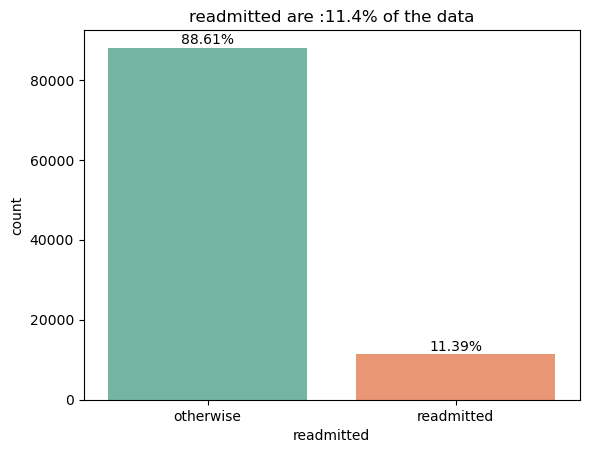

In [147]:
ax = plot_categorical_with_percent(df, column="readmitted", palette="Set2")
plt.title(f'readmitted are :{percent}% of the data')

## Approximately 11% of the population experiences rehospitalization, indicating an imbalanced classification scenario.

# 3. numeric features
Discover and Visualize the Data to Gain Insights

In [148]:
df.describe()

,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,9.934300e+04,99343.000000,99343.000000,99343.000000,99343.000000,99343.000000,99343.000000,99343.000000,99343.000000,99343.000000,99343.000000,99343.000000
mean,5.426117e+07,2.030259,3.517882,5.731083,4.379332,42.906929,1.334236,15.979062,0.369246,0.198444,0.630935,7.401709
std,3.873426e+07,1.446373,5.184359,4.065029,2.968409,19.610032,1.702786,8.094909,1.265142,0.937734,1.260428,1.941013
min,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,2.338675e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,4.541774e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,8.756007e+07,3.000000,3.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


admission_type_id, discharge_disposition_id and admission_source_id are ids thus need to be changed to categorical, We will deal with them later patient_nbr is index and not taking in to acount

Looking at the max and min values in the table above, we can see that there are outliers in number_outpatient, number_emergency, number_inpatient. We will deal with them later.

In [239]:
columns_to_drop

['admission_type_id', 'discharge_disposition_id', 'admission_source_id']

In [241]:
from copy import deepcopy

In [242]:
numerical_columns = df.select_dtypes(include=['int', 'float']).columns
df_numerical = deepcopy(df[numerical_columns])
columns_to_drop = [col for col in numerical_columns.values if '_id' in col]
df_numerical.drop(columns=columns_to_drop, inplace=True)


In [243]:
df_numerical

,patient_nbr,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
encounter_id,,,,,,,,,
2278392,8222157,1,41,0,1,0,0,0,1
149190,55629189,3,59,0,18,0,0,0,9
64410,86047875,2,11,5,13,2,0,1,6
500364,82442376,2,44,1,16,0,0,0,7
16680,42519267,1,51,0,8,0,0,0,5
...,...,...,...,...,...,...,...,...,...
443847548,100162476,3,51,0,16,0,0,0,9
443847782,74694222,5,33,3,18,0,0,1,9
443854148,41088789,1,53,0,9,1,0,0,13


In [17]:
numerical_columns = ['time_in_hospital',
                   'num_lab_procedures',
                   'num_procedures',
                   'num_medications',
                  'number_outpatient',
                  'number_emergency',
                  'number_inpatient',
                  'number_diagnoses']

array([[<Axes: title={'center': 'time_in_hospital'}>,
        <Axes: title={'center': 'num_lab_procedures'}>,
        <Axes: title={'center': 'num_procedures'}>],
       [<Axes: title={'center': 'num_medications'}>,
        <Axes: title={'center': 'number_outpatient'}>,
        <Axes: title={'center': 'number_emergency'}>],
       [<Axes: title={'center': 'number_inpatient'}>,
        <Axes: title={'center': 'number_diagnoses'}>, <Axes: >]],
      dtype=object)

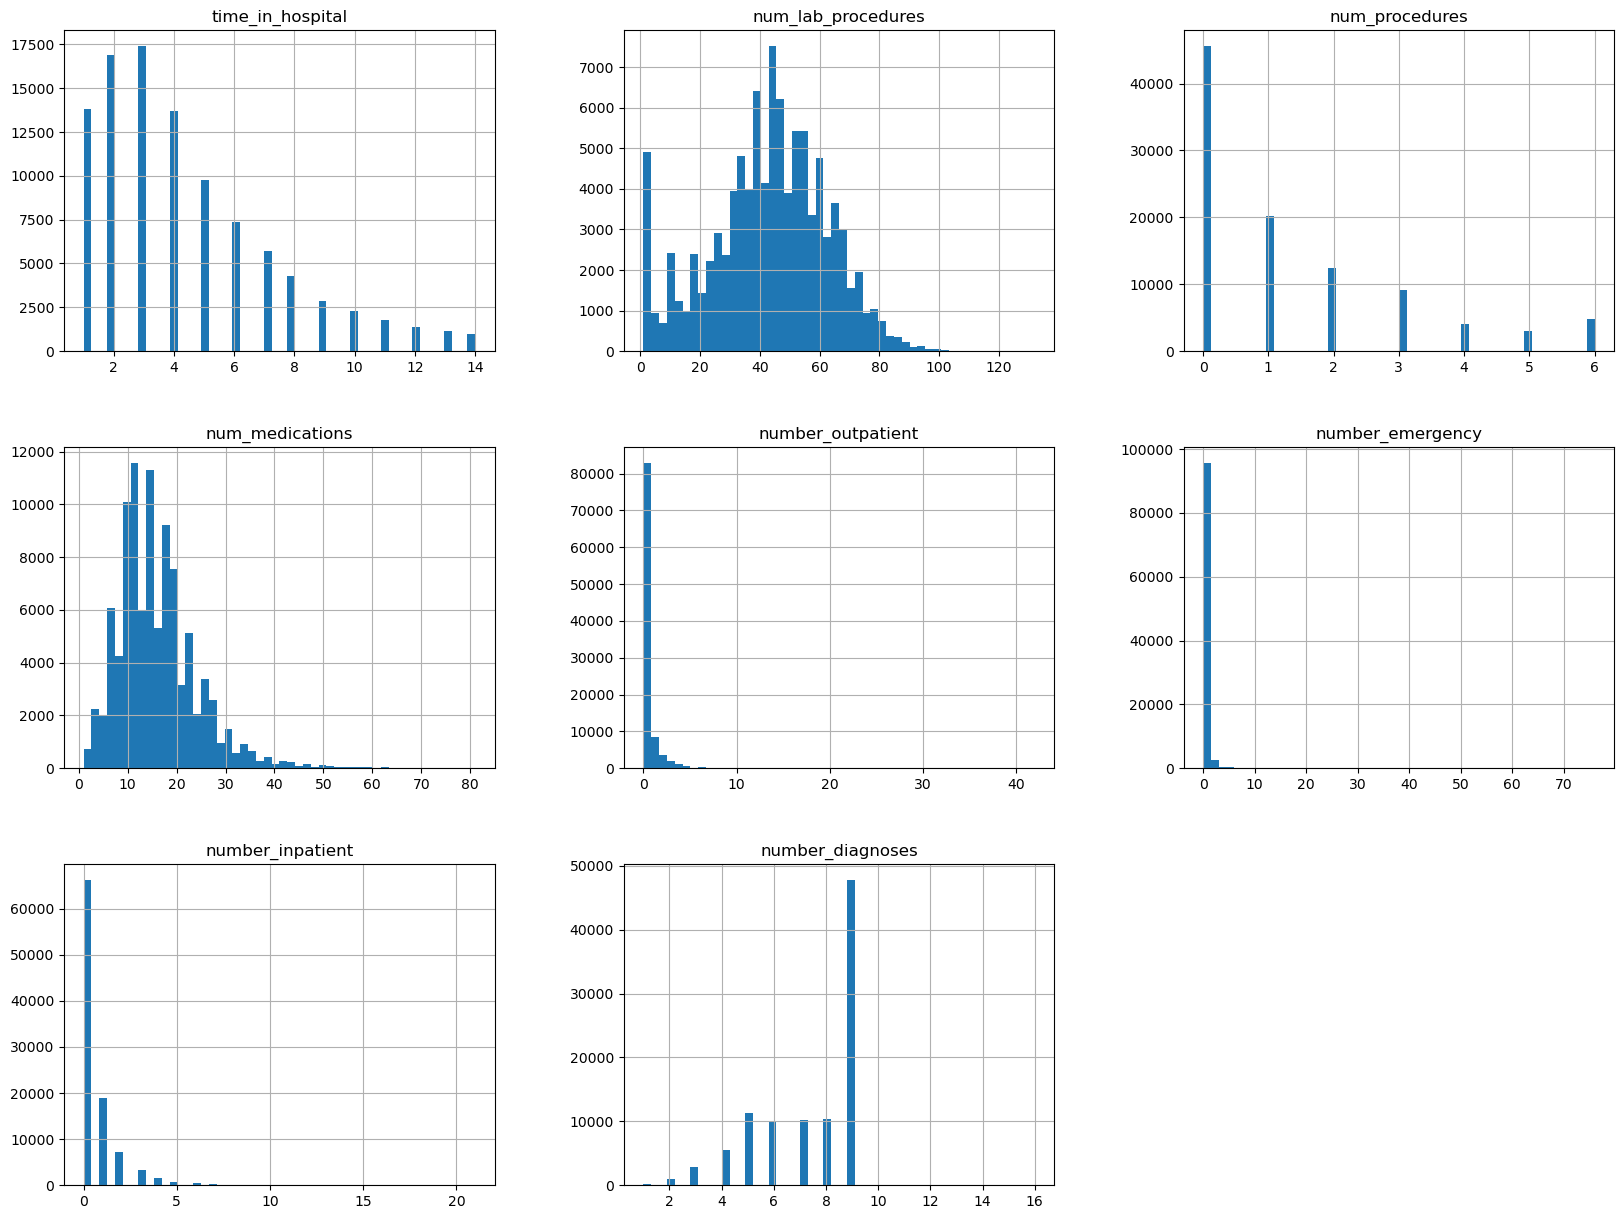

In [150]:
%matplotlib inline
import matplotlib.pyplot as plt
df[numerical_columns].hist(bins=50, figsize=(20,15))
plt.show()

before we remove any potential outliers we need to make sure that they are indeed non valid values which we can discard either based on domain knowledge or understanding of how the data was collected (e.g. due to some measurement errors).
Let's plot boxplots of the features with outliers and print the unique values in each one of them:

## 3.1 outliers

<Axes: xlabel='number_outpatient'>

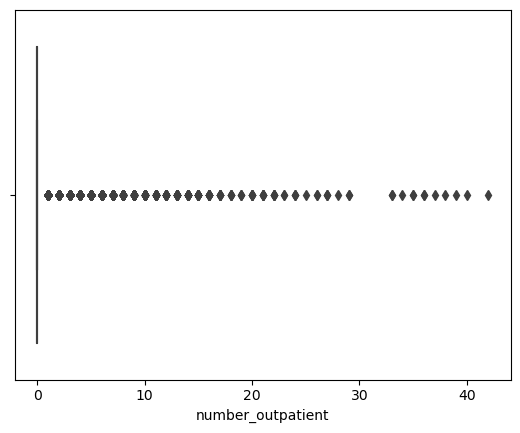

<Axes: xlabel='number_emergency'>

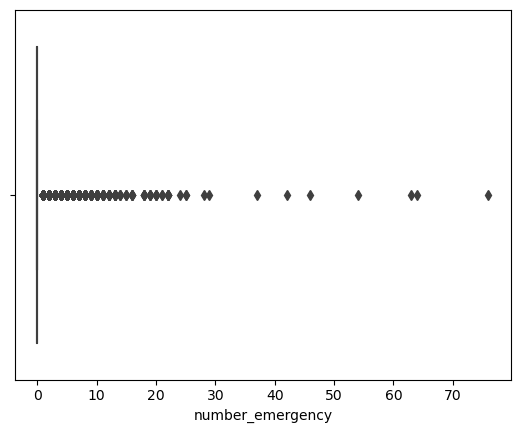

<Axes: xlabel='number_inpatient'>

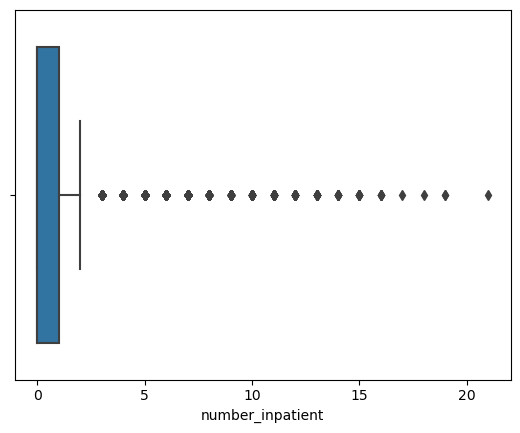

number_outpatient 99343 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 33 34 35 36 37 38 39 40 42]
number_emergency 99343 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 24 25
 28 29 37 42 46 54 63 64 76]
number_inpatient 6814 [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21]


In [151]:
dict_outliers = {}

def boxplot_outliers(col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1    #IQR is interquartile range.
    outliers_bool = (df[col] <= Q1 - 1.5 * IQR) | (df[col] >= Q3 + 1.5 *IQR)
    return df[col][outliers_bool]
col_to_check_for_outliers = ['number_outpatient', 'number_emergency', 'number_inpatient']

for col in col_to_check_for_outliers:
    dict_outliers.update({col : boxplot_outliers(col)})

# Creating individual plots
for var in col_to_check_for_outliers:
    sns.boxplot(x=var, data=df)
    plt.show()

for key, value in dict_outliers.items() :
    print (key, len(value), np.unique(value))

### we will deal with the outliers in the Cleaning Data section below

In [152]:
## 3.2 lets look at the diffrent distrebutions regarding the label

<Axes: xlabel='time_in_hospital', ylabel='count'>

Text(0.5, 1.0, 'Count Plot for time_in_hospital vs Readmitted')

<Axes: xlabel='time_in_hospital', ylabel='patient_nbr'>

Text(0.5, 1.0, 'distribution inside each population of time_in_hospital')

Text(0, 0.5, 'Percent out of population - %')

<Axes: xlabel='num_lab_procedures', ylabel='count'>

Text(0.5, 1.0, 'Count Plot for num_lab_procedures vs Readmitted')

<Axes: xlabel='num_lab_procedures', ylabel='patient_nbr'>

Text(0.5, 1.0, 'distribution inside each population of num_lab_procedures')

Text(0, 0.5, 'Percent out of population - %')

<Axes: xlabel='num_procedures', ylabel='count'>

Text(0.5, 1.0, 'Count Plot for num_procedures vs Readmitted')

<Axes: xlabel='num_procedures', ylabel='patient_nbr'>

Text(0.5, 1.0, 'distribution inside each population of num_procedures')

Text(0, 0.5, 'Percent out of population - %')

<Axes: xlabel='num_medications', ylabel='count'>

Text(0.5, 1.0, 'Count Plot for num_medications vs Readmitted')

<Axes: xlabel='num_medications', ylabel='patient_nbr'>

Text(0.5, 1.0, 'distribution inside each population of num_medications')

Text(0, 0.5, 'Percent out of population - %')

<Axes: xlabel='number_outpatient', ylabel='count'>

Text(0.5, 1.0, 'Count Plot for number_outpatient vs Readmitted')

<Axes: xlabel='number_outpatient', ylabel='patient_nbr'>

Text(0.5, 1.0, 'distribution inside each population of number_outpatient')

Text(0, 0.5, 'Percent out of population - %')

<Axes: xlabel='number_emergency', ylabel='count'>

Text(0.5, 1.0, 'Count Plot for number_emergency vs Readmitted')

<Axes: xlabel='number_emergency', ylabel='patient_nbr'>

Text(0.5, 1.0, 'distribution inside each population of number_emergency')

Text(0, 0.5, 'Percent out of population - %')

<Axes: xlabel='number_inpatient', ylabel='count'>

Text(0.5, 1.0, 'Count Plot for number_inpatient vs Readmitted')

<Axes: xlabel='number_inpatient', ylabel='patient_nbr'>

Text(0.5, 1.0, 'distribution inside each population of number_inpatient')

Text(0, 0.5, 'Percent out of population - %')

<Axes: xlabel='number_diagnoses', ylabel='count'>

Text(0.5, 1.0, 'Count Plot for number_diagnoses vs Readmitted')

<Axes: title={'center': 'Count Plot for number_diagnoses'}, xlabel='number_diagnoses', ylabel='patient_nbr'>

Text(0.5, 1.0, 'distribution inside each population of number_diagnoses')

Text(0, 0.5, 'Percent out of population - %')

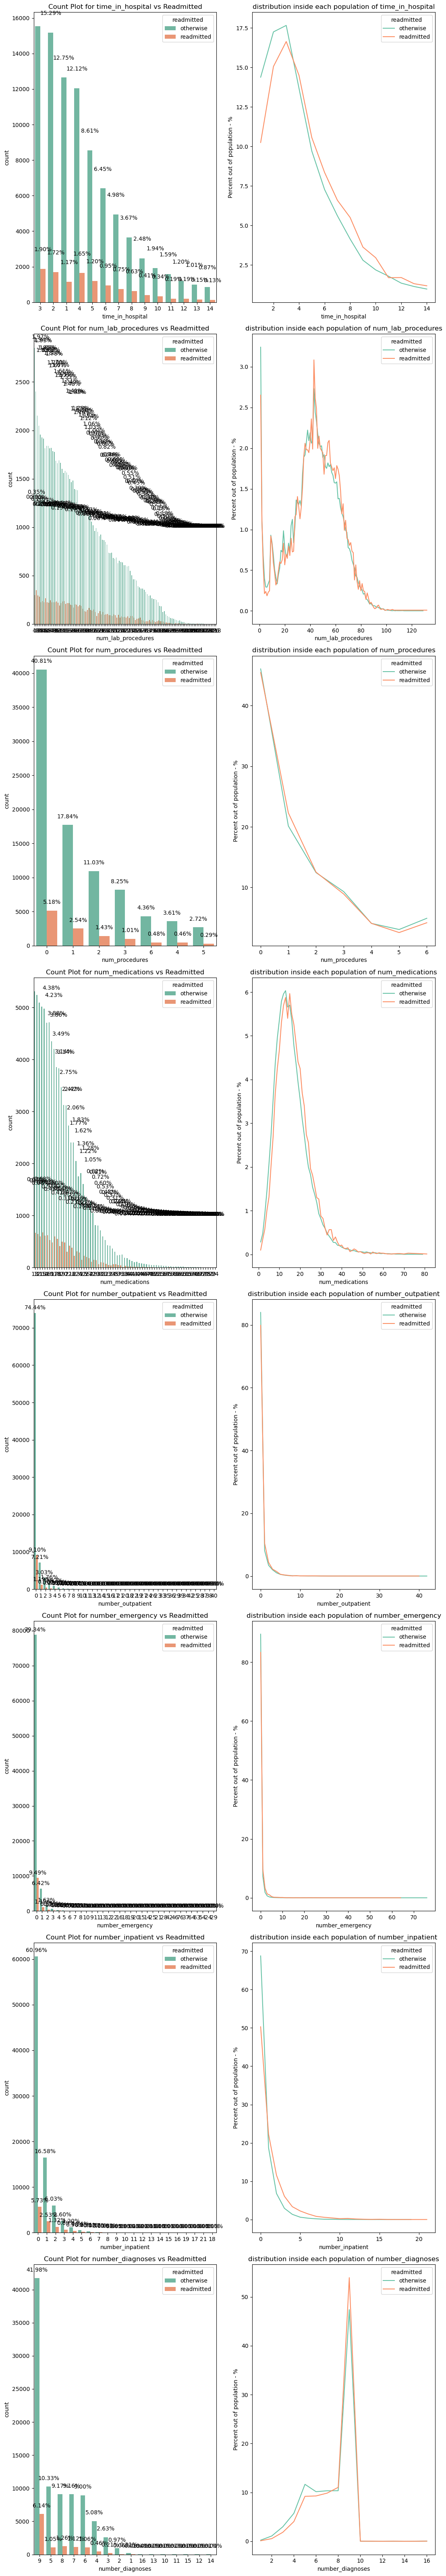

In [153]:

fig, axes = plt.subplots(nrows=len(numerical_columns), ncols=2, figsize=(11, 8 * len(numerical_columns)))

# Loop through numerical columns and create count plots on separate axes
for i, column in enumerate(numerical_columns):
    # I want to see how the numerical data lokks with the two readmitted groups
    plot_categorical_with_percent(data=df, column=column, hue='readmitted', palette="Set2", ax=axes[i, 0])
    # sns.countplot(x=column, hue='readmitted', data=df, palette="Set2", ax=axes[i, 0])
    axes[i, 0].set_title(f'Count Plot for {column} vs Readmitted')
   
    # I also want to see the distribution inside each population - this is becouse of uneven samples
    percent_data = (df.groupby(['readmitted', column]).count()['patient_nbr'] / df.groupby('readmitted').count()['patient_nbr'] *100).reset_index()
    sns.lineplot(data=percent_data, hue='readmitted', x=column, y='patient_nbr', ax=axes[i,1], palette="Set2",)
    axes[i, 1].set_title(f'distribution inside each population of {column}')
    axes[i, 1].set_ylabel('Percent out of population - %') 
        
# Adjust layout
plt.tight_layout()
plt.show()

In [154]:
# To see the diffrence between the two groups we ploted both an histogram of the numerical values and the papulation destribution, the distribution allows us to compere the unbalanced data

# out of this plots we see can't see a big difrence in: 'num_lab_procedures', 'num_procedures', 'number_outpatient' and 'number_emergency'.
# and we can see some difrence in: 'time_in_hospital' (higher values in longer time for readmitted), 'num_medications' (more medications for readmitted), 'number_inpatient' (pepole that readmit tend to go more to hospitals)
# and finaly number_diagnose (readmitted pations have more diagnoses)

## 3.3 Looking for Correlations

<Figure size 1200x1000 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Correlation Plot of df')

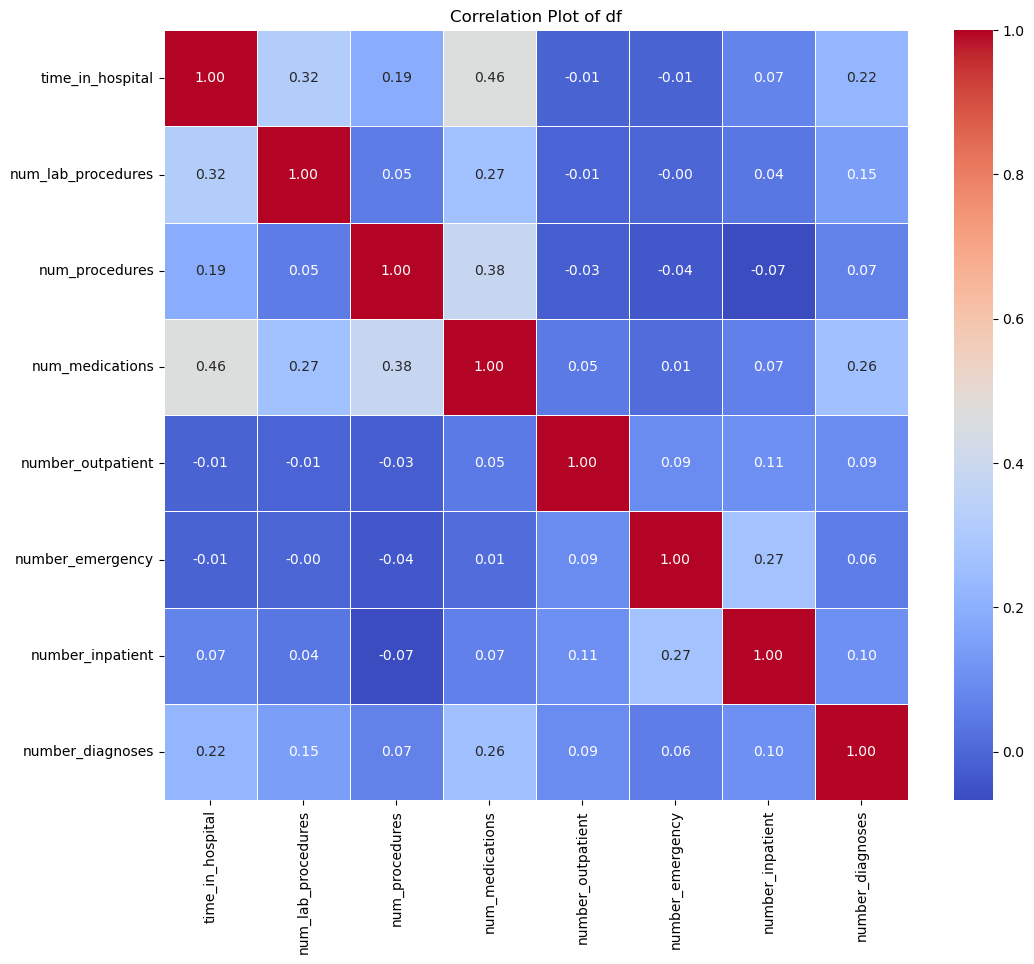

In [155]:
correlation_matrix = df[numerical_columns].corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap using seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Show the plot
plt.title("Correlation Plot of df")
plt.show()

array([[<Axes: xlabel='time_in_hospital', ylabel='time_in_hospital'>,
        <Axes: xlabel='num_lab_procedures', ylabel='time_in_hospital'>,
        <Axes: xlabel='num_procedures', ylabel='time_in_hospital'>,
        <Axes: xlabel='num_medications', ylabel='time_in_hospital'>,
        <Axes: xlabel='number_outpatient', ylabel='time_in_hospital'>,
        <Axes: xlabel='number_emergency', ylabel='time_in_hospital'>,
        <Axes: xlabel='number_inpatient', ylabel='time_in_hospital'>,
        <Axes: xlabel='number_diagnoses', ylabel='time_in_hospital'>],
       [<Axes: xlabel='time_in_hospital', ylabel='num_lab_procedures'>,
        <Axes: xlabel='num_lab_procedures', ylabel='num_lab_procedures'>,
        <Axes: xlabel='num_procedures', ylabel='num_lab_procedures'>,
        <Axes: xlabel='num_medications', ylabel='num_lab_procedures'>,
        <Axes: xlabel='number_outpatient', ylabel='num_lab_procedures'>,
        <Axes: xlabel='number_emergency', ylabel='num_lab_procedures'>,
       

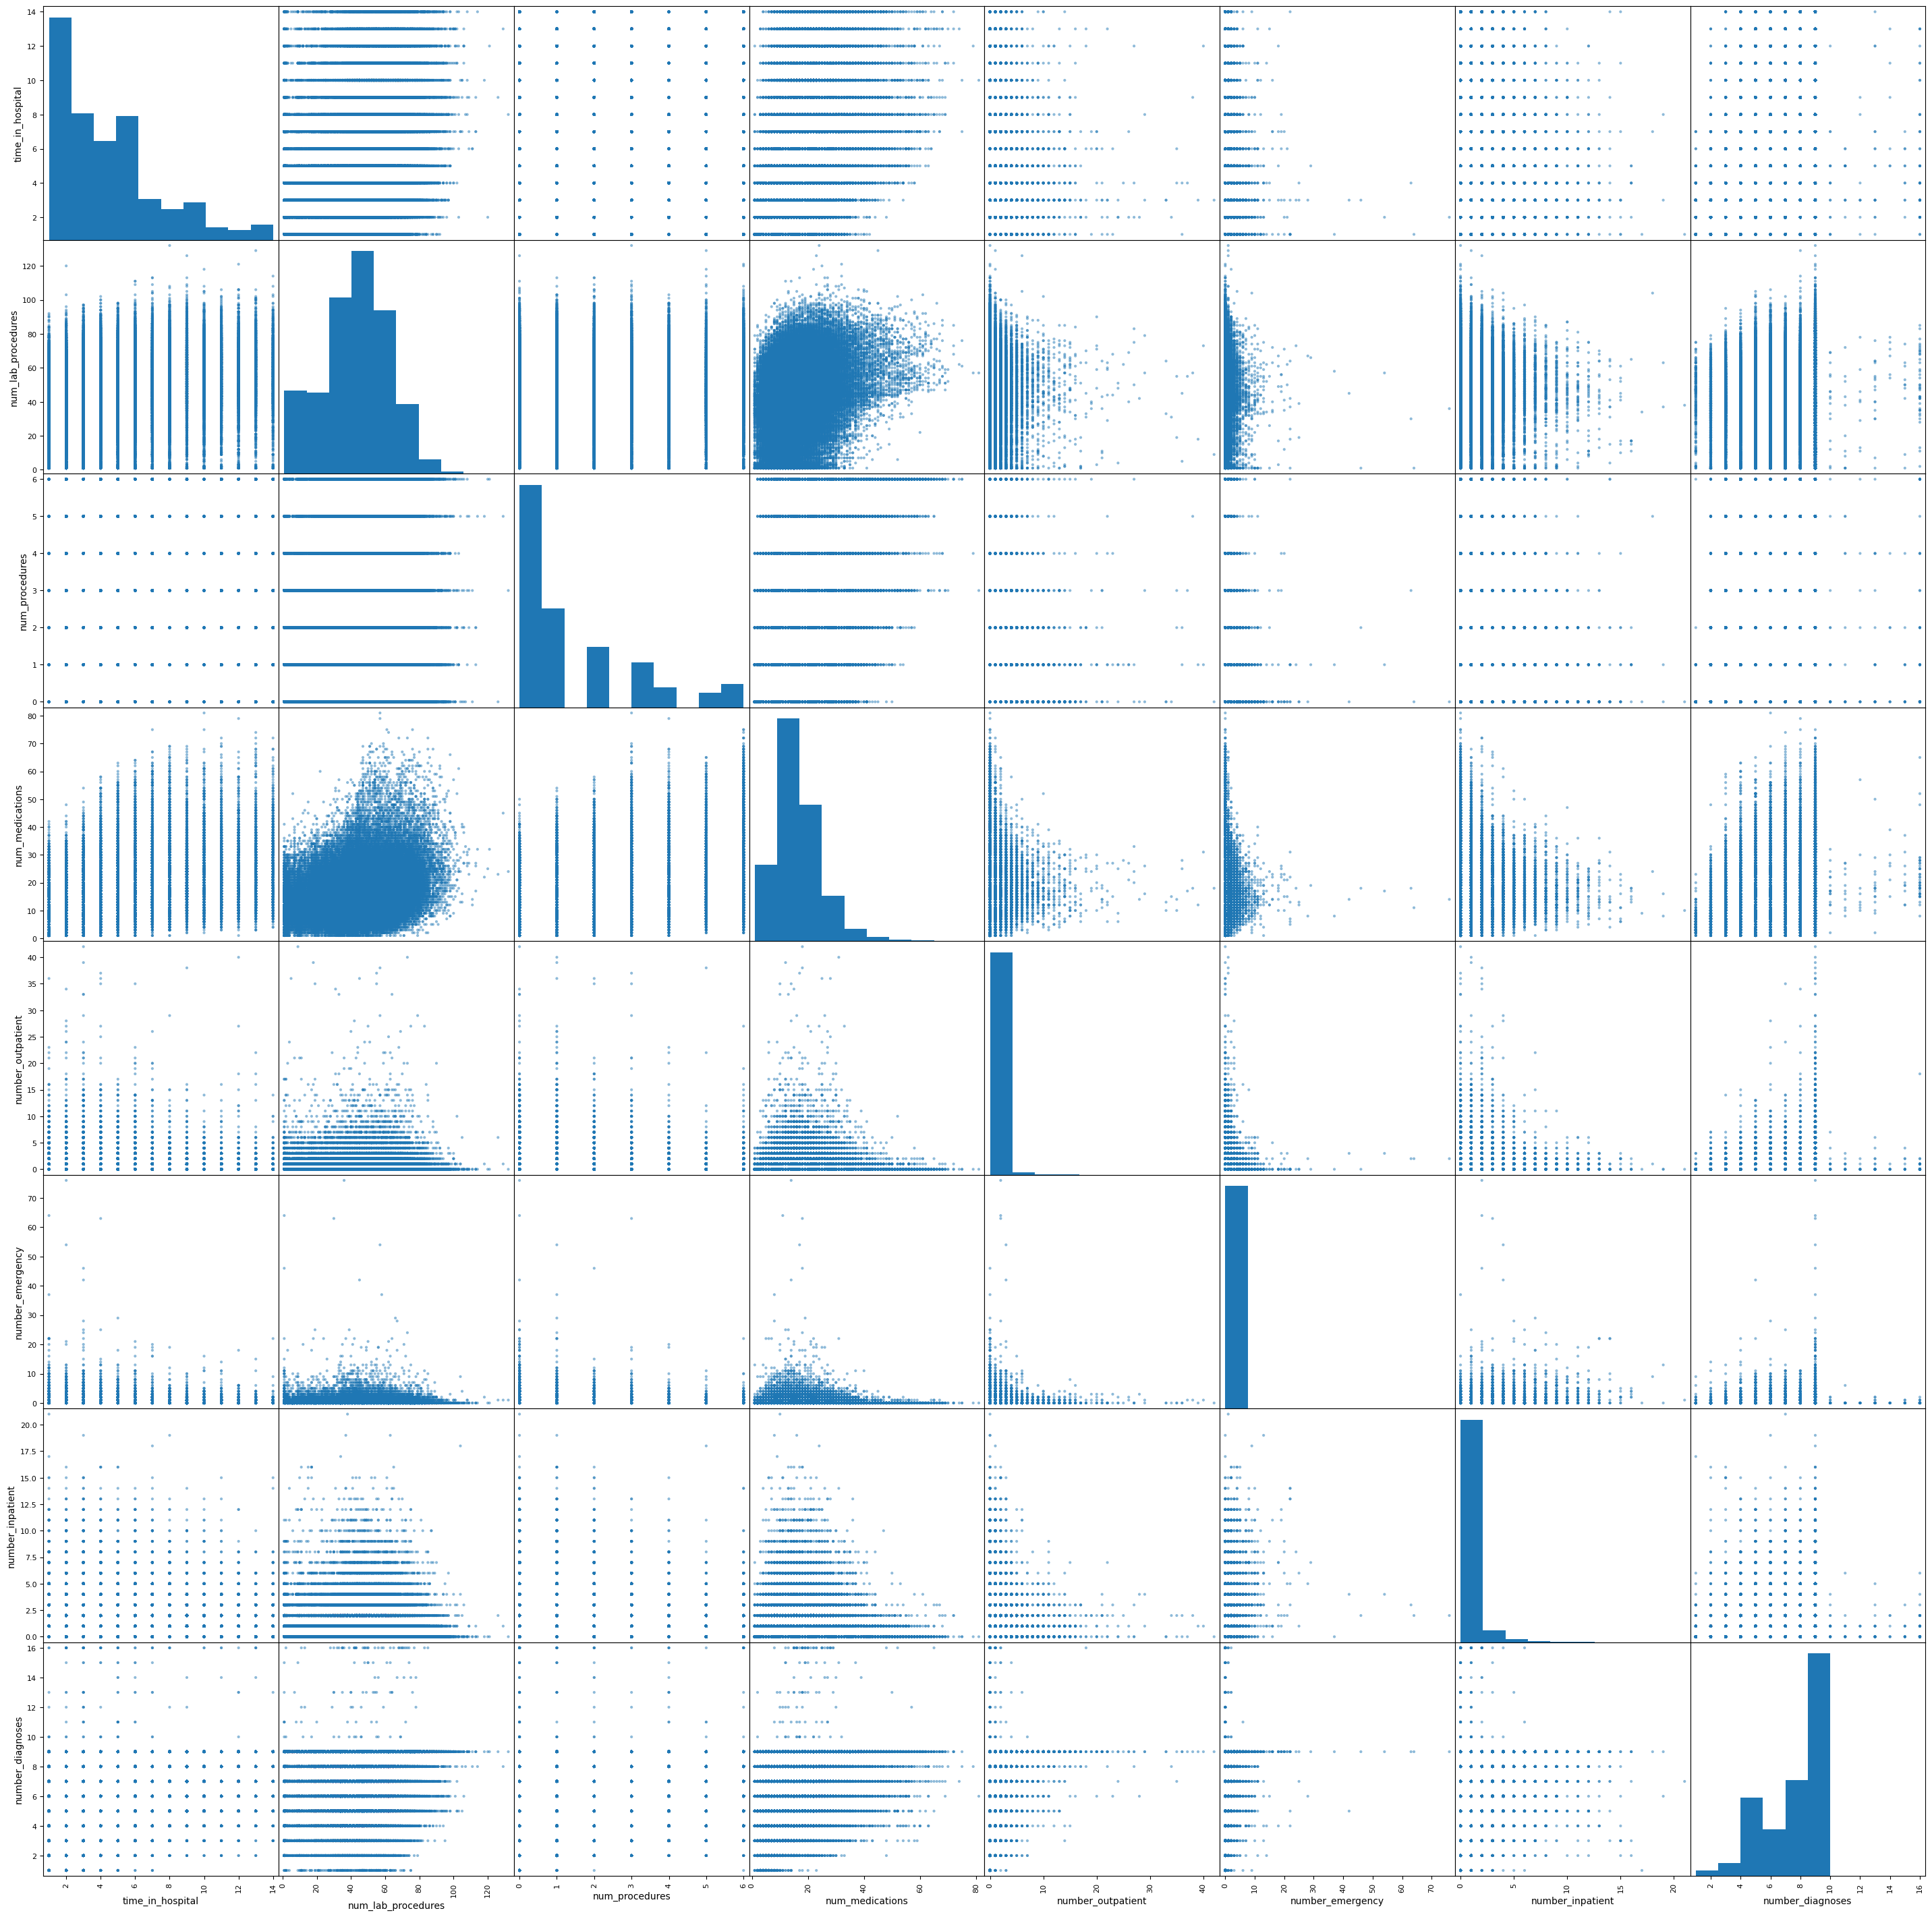

In [156]:
from pandas.plotting import scatter_matrix
scatter_matrix(df[numerical_columns], figsize=(36, 36))


In [157]:

# we can see some correlation between time in the hospital and procedures and number of medications
# to get beter resulotion of the diffrences we need to remove the outliers 

# We need to use RubustScalar to scale this columns!

# 4 Categorical columns
lets look on the categorical columns in our data
1. we want to look on the namber of catagories there are in each category
2. we want to remove categories with a single value or a value that is higher then 95 percent of the data
3. we want to reduse the dimentionalty of the categories

In [18]:
# lets look on all the categirical coloumns and see how many unique values they have and waht is the percent
df_categorical = df.drop(columns=numerical_columns)
df_categorical.drop(columns=['patient_nbr'], inplace=True)

# at the end we will turn it to categorical
# df_categorical = df_categorical.astype('category')


In [19]:
from copy import deepcopy

In [29]:
df_categorical_1 = deepcopy(df_categorical)

In [44]:
def group_cat_column_by_dict(df, column, group_dict):
    '''group multiple values inside a feature using dict:    {new_value: [list_of_old_values]}'''
    for key in group_dict.keys():
        df.loc[df[column].isin(group_dict[key]), column] = key
    if not 'other' in group_dict:
        df.loc[~df[column].isin(group_dict.keys()), column] = 'other'
    df[column].replace(np.nan, 'missing')
    return df
    
group_dict={'other': [1, 2], }
df_categorical = group_cat_column_by_dict(df_categorical, 'admission', group_dict)
df_categorical.rename(columns={'admission_type_id': 'admission'}, inplace=True)

In [45]:
group_dict.keys()

dict_keys(['other'])

In [46]:
df_categorical.loc[~df_categorical['admission'].isin(group_dict.keys()), 'admission'] = 'other'

In [47]:
df_categorical['admission']

encounter_id
2278392      other
149190       other
64410        other
500364       other
16680        other
             ...  
443847548    other
443847782    other
443854148    other
443857166    other
443867222    other
Name: admission, Length: 101766, dtype: object

In [159]:
categorical_columns = ['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'medical_specialty',
       'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted']

## 4.1 Remove low variance features

In [160]:
# Remove features with zero variance and perhaps also those with small variance
def fraction_of_unique_values(column):
    '''gets the fraction and counts for each column in a df, based on df.nunique function'''
    try:
        unique_values, counts = np.unique(df[column], return_counts=True)
    except TypeError:
        unique_values, counts = np.unique(df[column].astype(str), return_counts=True)
        
    fraction = 100 * (counts / sum(counts))
    
    return np.sort(fraction)[::-1], np.sort(counts)[::-1]

def is_one_of_the_values_have_bigger_fraction_then(fraction, threshold=95):
    '''cheack if a value in a list is bigger of threshold, return bool'''
    return (fraction > threshold).any()


def remove_features_with_low_variance(df, threshold=95):
    '''remove low variance fetures based ot threshold'''
    column_unique_counts = pd.DataFrame(df_categorical.nunique().sort_values(), columns=['unique']).reset_index()
    column_unique_counts.rename(columns={'index': 'column'}, inplace=True)
    column_unique_counts[['fraction_of_unique_values', 'counts']] = pd.DataFrame(column_unique_counts['column'].apply(fraction_of_unique_values).apply(pd.Series))
    coloumn_with_bed_value_destribution = column_unique_counts.apply(lambda row: is_one_of_the_values_have_bigger_fraction_then(row.fraction_of_unique_values, threshold), axis=1)
    coloumns_to_remove = column_unique_counts[coloumn_with_bed_value_destribution].column.values
    return df.drop(columns=coloumns_to_remove)
    
df_categorical = remove_features_with_low_variance(df_categorical)




## 4.2 veiw featurs uniqe value
we are doimg this to fimd places where we could reduse dimentionalty

<Figure size 800x4000 with 0 Axes>

0it [00:00, ?it/s]

<Axes: >

1it [00:00,  9.93it/s]

<Axes: >

<Axes: >

3it [00:00, 11.49it/s]

<Axes: >

<Axes: >

5it [00:00, 11.96it/s]

<Axes: >

<Axes: >

7it [00:00,  7.56it/s]

<Axes: >

8it [00:04,  1.04s/it]

<Axes: >

9it [00:06,  1.31s/it]

<Axes: >

10it [00:09,  1.73s/it]

<Axes: >

11it [00:10,  1.29s/it]

<Axes: >

12it [00:10,  1.04it/s]

<Axes: >

13it [00:10,  1.39it/s]

<Axes: >

14it [00:10,  1.82it/s]

<Axes: >

15it [00:10,  2.31it/s]

<Axes: >

16it [00:10,  2.82it/s]

<Axes: >

17it [00:10,  3.42it/s]

<Axes: >

18it [00:10,  4.01it/s]

<Axes: >

19it [00:11,  4.70it/s]

<Axes: >

20it [00:11,  5.33it/s]

<Axes: >

21it [00:11,  5.87it/s]

<Axes: >

22it [00:11,  1.92it/s]


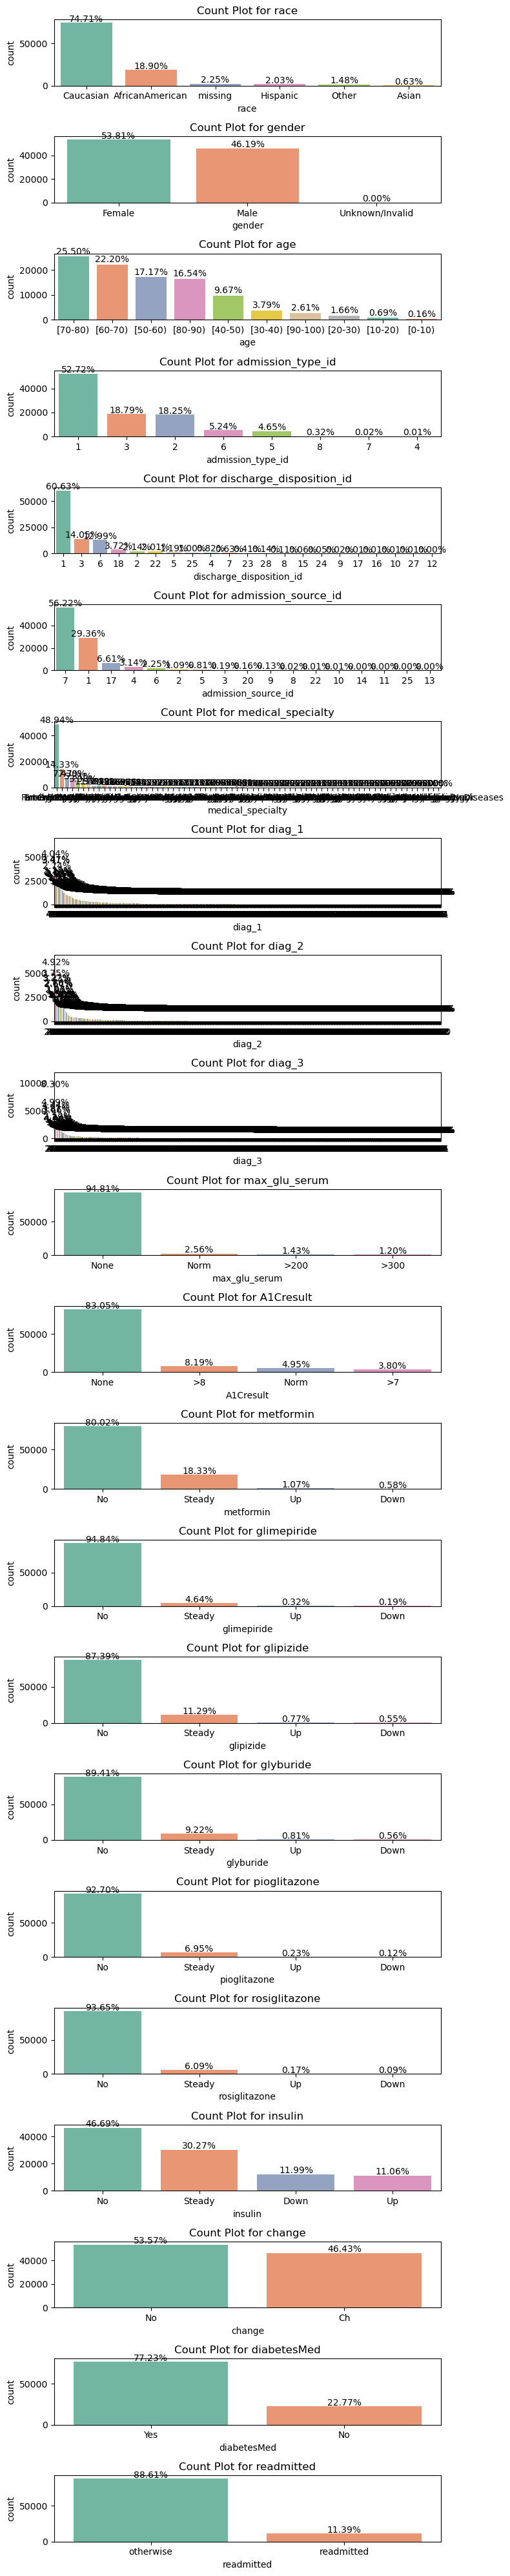

In [161]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# We would like to see how many categories we have and what the distribution is. We will modify the different categories to reduce dimensionality where possible
plt.figure(figsize=(8, 40))  
# Create a subplot with 22 rows and 1 column
plt.subplots_adjust(hspace=0.5)  
# Loop through each column and create count plots
for i, column in tqdm(enumerate(df_categorical.columns, 1)):  # Start counting from 1 for subplot index
    plt.subplot(22, 1, i)
    ax = plot_categorical_with_percent(df_categorical, column, palette="Set2")

# Adjust layout
plt.tight_layout()
plt.show()


## 4.3 inspect gender

<Axes: title={'center': 'Count Plot for gender'}, xlabel='gender', ylabel='count'>

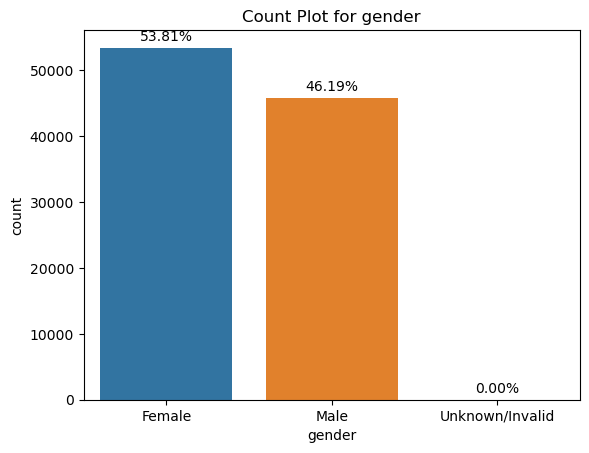

In [162]:
# lets look at gender dest:
plot_categorical_with_percent(df_categorical, 'gender')

<Axes: title={'center': 'Count Plot for gender'}, xlabel='gender', ylabel='count'>

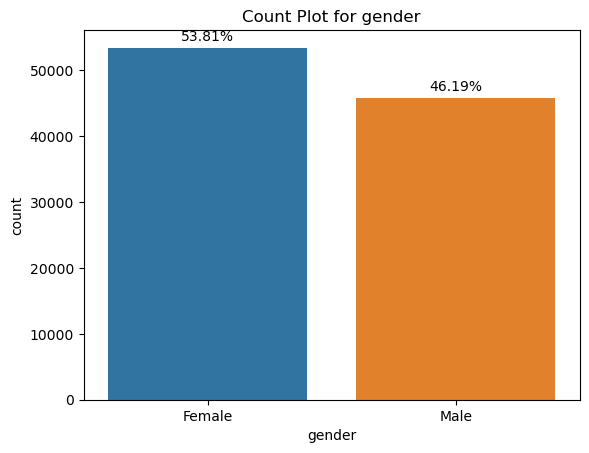

In [163]:
# we will remove rwos with inknown gender
def modify_feature_indexs(df, column, value_to_remove='Unknown/Invalid'):
    '''returns a list of indexes based on column and value'''
    index_to_drop = df[(df_categorical.gender == 'Unknown/Invalid')].index
    return index_to_drop
    
column = 'gender';  value_to_remove='Unknown/Invalid'
indexs_of_gender_to_drop = modify_feature_indexs(df_categorical, column, value_to_remove=value_to_remove)

df.drop(index=indexs_of_gender_to_drop, inplace=True)
df_categorical.drop(index=indexs_of_gender_to_drop, inplace=True)


plot_categorical_with_percent(df_categorical, column)

## 4.4 inspect discharge_disposition

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 12, 15, 16, 17, 18, 22, 23,
        24, 25, 27, 28], dtype=int64),
 array([60232,  2128, 13954,   815,  1184, 12902,   623,   108,    21,
            6,     3,    63,    11,    14,  3691,  1992,   412,    48,
          989,     5,   139], dtype=int64))

<Axes: title={'center': 'Count Plot for discharge_disposition_id'}, xlabel='discharge_disposition_id', ylabel='count'>

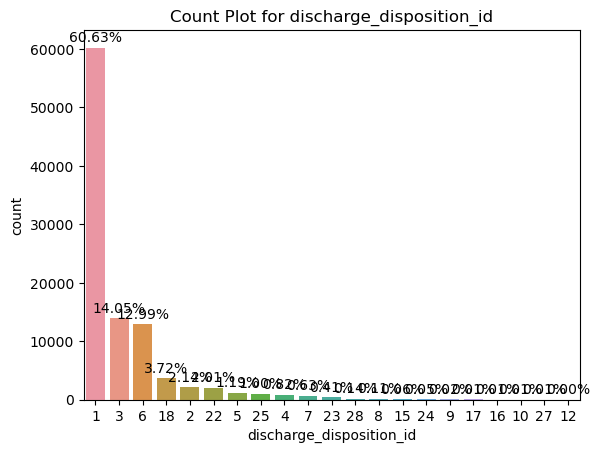

In [164]:
# change the discharge to categorical, reduce to home/other
np.unique(df_categorical.discharge_disposition_id, return_counts=True)
plot_categorical_with_percent(df_categorical,'discharge_disposition_id')

<Axes: title={'center': 'Count Plot for discharge'}, xlabel='discharge', ylabel='count'>

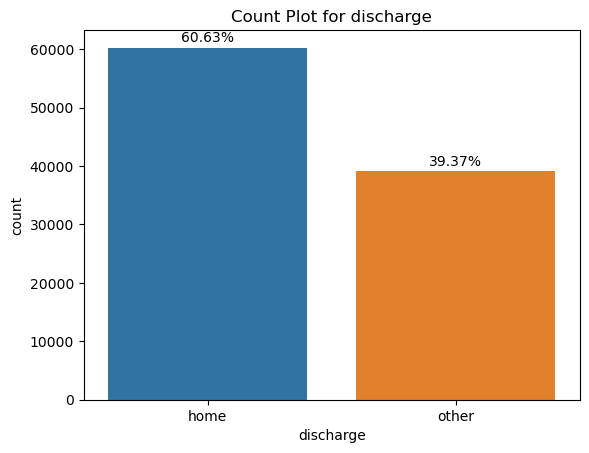

In [165]:
# change the discharge to categorical, reduce to home/other
def binary_grouping(df, column, equal_to, new_value, other= 'other'):
    df.loc[df[column]!= equal_to, column] = other
    df.loc[df[column] == equal_to, column] = 'home'
    return df

df_categorical.rename(columns={'discharge_disposition_id': 'discharge'}, inplace=True)
df_categorical = binary_grouping(df_categorical, 'discharge', equal_to=1, new_value='home', other='other')


plot_categorical_with_percent(df_categorical,'discharge')
# change the discharge to categorical, reduce to home/other
# np.unique(df_with_diag.discharge, return_counts=True)
# df_with_diag = pd.get_dummies(df_with_diag, columns=['discharge'], prefix_sep='_')

## 4.5 inspect admission_type_id
change the admission to categorical, reduce to other, high_prayority, clinic_referral
admission_type_id	description
1	Emergency
2	Urgent
3	Elective
4	Newborn
5	Not Available
6	NULL
7	Trauma Center
8	Not Mapped
we are grouping togeter: 8,6,5 toggeter as 'other', 1,2 as high_prayority and else as clinic referral




<Axes: title={'center': 'Count Plot for admission_type_id'}, xlabel='admission_type_id', ylabel='count'>

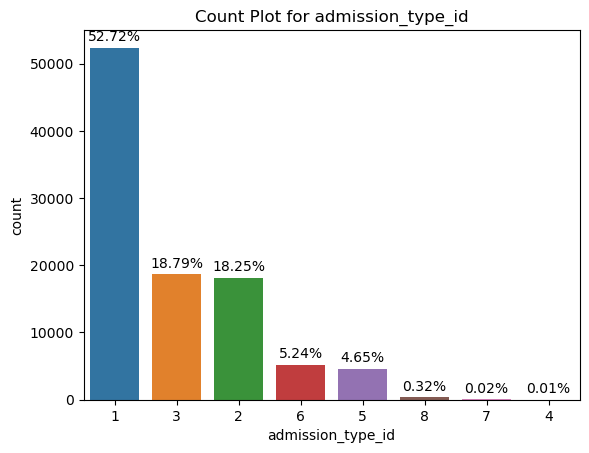

In [166]:
# np.unique(df_categorical.admission_type_id, return_counts=True)
plot_categorical_with_percent(df_categorical,'admission_type_id')

(array(['clinic_referral', 'high_prayority', 'other'], dtype=object),
 array([18695, 70501, 10144], dtype=int64))

<Axes: title={'center': 'Count Plot for admission'}, xlabel='admission', ylabel='count'>

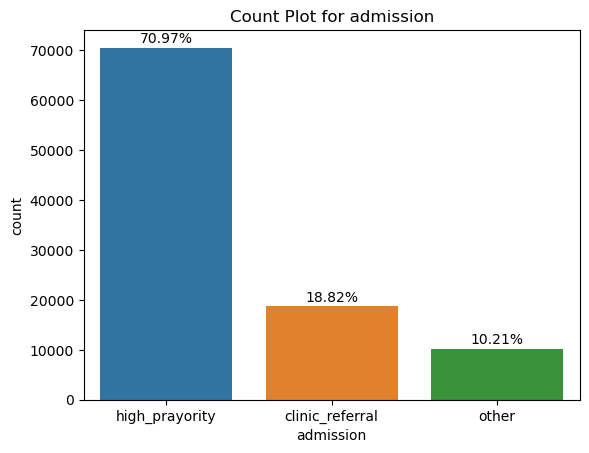

In [167]:
def group_cat_column_by_dict(df, column, group_dict):
    for key in group_dict.keys():
        df.loc[df_categorical[column].isin(group_dict[key]), column] = key
    return df
    
group_dict={'other': [5, 6, 8], 'high_prayority': [1, 2], 'clinic_referral': [3, 4, 7]}
df_categorical = group_cat_column_by_dict(df_categorical, 'admission_type_id', group_dict)
df_categorical.rename(columns={'admission_type_id': 'admission'}, inplace=True)

np.unique(df_categorical.admission, return_counts=True)
plot_categorical_with_percent(df_categorical,'admission')

## 4.6 inspect race
We see that caucasian and African American are ~92 % of the data so we will unite oTHER, ASIAN AND HISPANIC to reduce dimentionalty


<Axes: title={'center': 'Count Plot for race'}, xlabel='race', ylabel='count'>

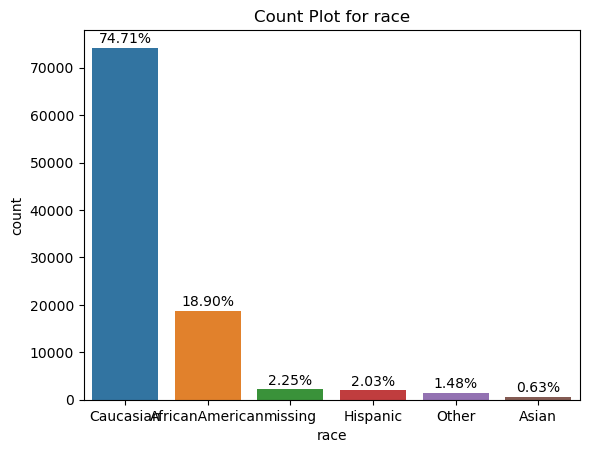

In [168]:
plot_categorical_with_percent(df_categorical,'race')

<Axes: title={'center': 'Count Plot for race'}, xlabel='race', ylabel='count'>

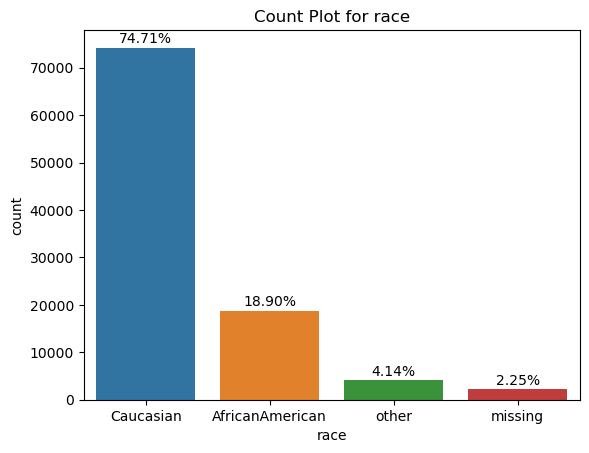

In [169]:
group_dict={'other': ['Other', 'Hispanic', 'Asian']}
df_categorical = group_cat_column_by_dict(df_categorical, 'race', group_dict)
plot_categorical_with_percent(df_categorical,'race')

## 4.7 inspect age

<Axes: title={'center': 'Count Plot for age'}, xlabel='age', ylabel='count'>

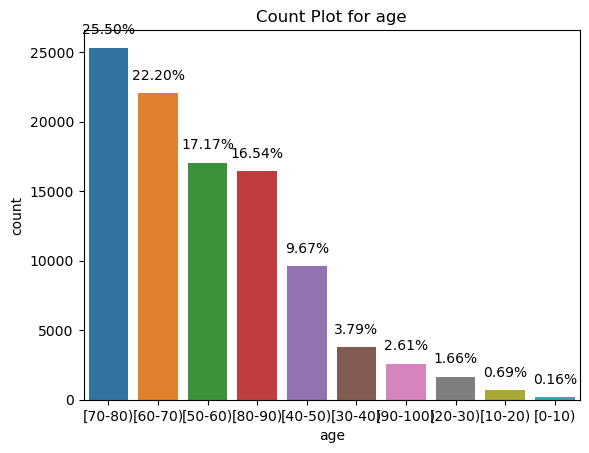

In [170]:
# age groups are divided to tree: yung- <30, midlife 30<60 and old 60+ and turn to categorical
# np.unique(df_categorical.age.astype(str), return_counts=True)
plot_categorical_with_percent(df_categorical,'age')


<Axes: title={'center': 'Count Plot for age'}, xlabel='age', ylabel='count'>

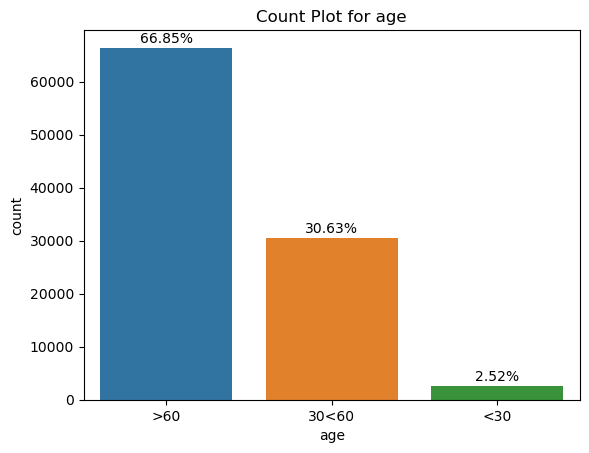

In [171]:

group_dict={'<30': ['[0-10)', '[10-20)', '[20-30)'], '30<60': ['[30-40)', '[40-50)', '[50-60)'], '>60': ['[60-70)', '[70-80)', '[80-90)', '[90-100)']}
df_categorical = group_cat_column_by_dict(df_categorical, 'age', group_dict)

# df_categorical = pd.get_dummies(df_categorical, columns=['age'], prefix_sep='_')
plot_categorical_with_percent(df_categorical,'age')

## 4.8 inspect medical_specialty

<Axes: title={'center': 'Count Plot for medical_specialty'}, xlabel='medical_specialty', ylabel='count'>

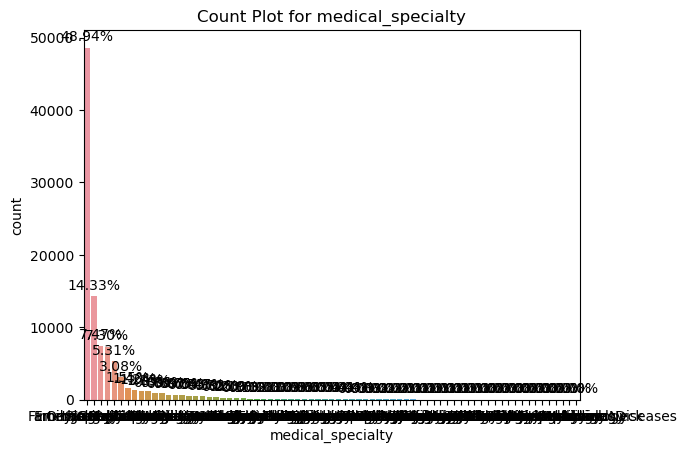

In [173]:
# lets look at medical specialety
# unique, counts = np.unique(df_categorical.medical_specialty.astype(str), return_counts=True)
# unique, counts
plot_categorical_with_percent(df_categorical, 'medical_specialty')
# There are seven mediacl_specialties that are most common, we will reduce the dimensionality, by tacking only the most common and all other are other 

<Axes: title={'center': 'Count Plot for medical_specialty'}, xlabel='medical_specialty', ylabel='count'>

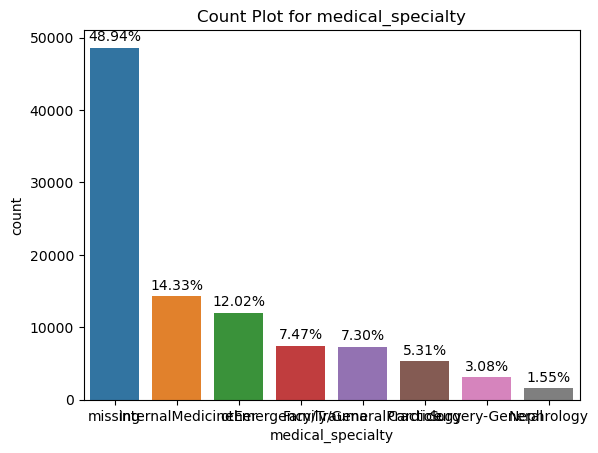

In [174]:
# catagories medical specialety


def keep_top_values(df, column, keep_amount=7):
    unique, counts = np.unique(df_categorical[column].astype(str), return_counts=True)
    sorted_indices = np.argsort(counts)[::-1]  # Reverse order to get descending sort indices
    sorted_unique = unique[sorted_indices]
    df.loc[~(df[column].isin(sorted_unique[:7])), column] ='other'
    return df
   
# we will take all 6 top type of specialeties and missing and we are creating new type : 'other'

df_categorical = keep_top_values(df_categorical, 'medical_specialty', keep_amount=7)
# df_categorical.loc[~(df_categorical.medical_specialty.isin(sorted_unique[:7])), 'medical_specialty'] ='other'
# np.unique(df_categorical.medical_specialty.astype(str), return_counts=True)
plot_categorical_with_percent(df_categorical, 'medical_specialty')
# df_categorical = pd.get_dummies(df_categorical, columns=['medical_specialty'], prefix_sep='_')

# 5. Feature Engineering

From going over the data we found multiple data editing that can be beneficial:
1. 'encounter_id' and 'patient_nbr' are identifiers and not variables
2.  'admission_type_id', 'discharge_disposition_id', and 'admission_source_id': are numerical, They should be considered categorical.
3.  'examide' and 'citoglipton' have only one unique value thus, not contributing ('No' and 'No') and removed
4.  'acetohexamide',  'tolbutamide', 'troglitazone', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone' in all this columns we find two unique values, but one value is in 99.99 percent of the data, we thus remove this columns 
5. following 4 we dicided to remove all coloumns that 95 percent or more is jest one value : ['examide', 'citoglipton', 'acetohexamide', 'tolbutamide','troglitazone', 'glimepiride-pioglitazone','metformin-rosiglitazone', 'metformin-pioglitazone','glipizide-metformin', 'tolazamide', 'glyburide-metformin','acarbose', 'miglitol', 'chlorpropamide', 'nateglinide',
'repaglinide']
6.there are 913 diagnostics, to reduse the dimentinalety we unite codeons based on the  major classification of it, we mannaged to reduse the diag to 19 and we changed it to be catagorical
7. gender to categorical: male, female, we removed unknown only 3
8. We changed the discharge to home/other and changed to categorical
9. addmition_id is changed to categorical, with 3 catagories 'clinic referral', 'high_prayority and other
10. race is cahnged to categorical,  nan values are turned to missing and we unite low repits values (asian and hispanic) with other
11. 6.  


## 5.1 set encounters

If you have diabetes, an ideal HbA1c level is 48mmol/mol (6.5%) or below. If you're at risk of developing type 2 diabetes,
 your target HbA1c level should be below 42mmol/mol (6%)


We considered four groups of encounters: 

(1) no HbA1c test performed.

(2) HbA1c performed and in normal range.

(3) HbA1c performed and the result is greater than 7% with no change in diabetic medications.

(4) HbA1c performed, result is greater than 7%, and diabetic medication was changed.


<Axes: title={'center': 'Count Plot for A1Cresult'}, xlabel='A1Cresult', ylabel='count'>

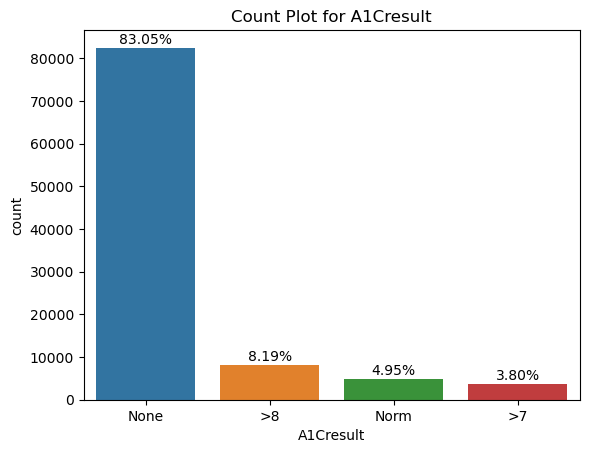

In [175]:
plot_categorical_with_percent(df_categorical, 'A1Cresult')

<Axes: title={'center': 'Count Plot for change'}, xlabel='change', ylabel='count'>

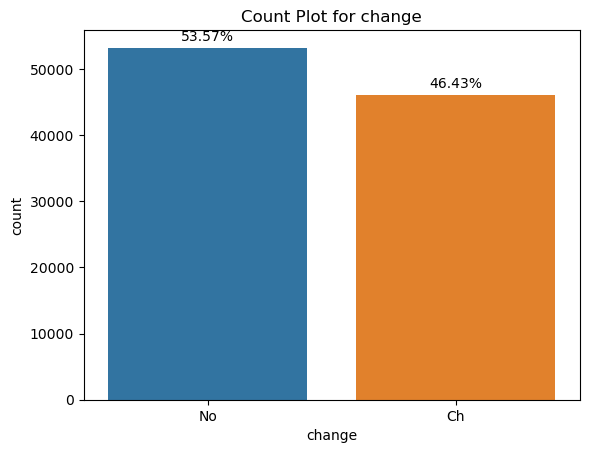

In [176]:
plot_categorical_with_percent(df_categorical, 'change')

<Axes: title={'center': 'Count Plot for encounters'}, xlabel='encounters', ylabel='count'>

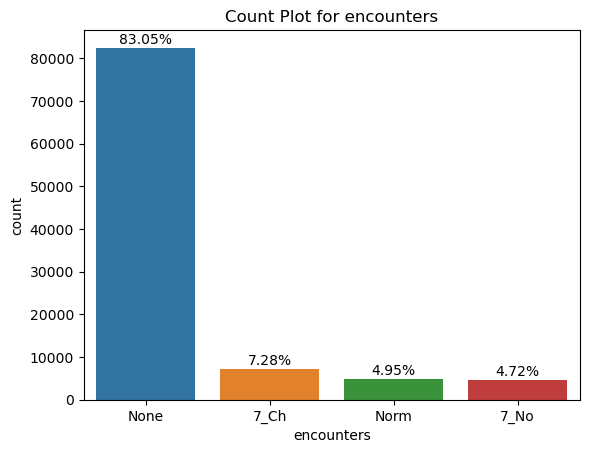

In [182]:
def set_encounters(df):
    '''set encounters for each patient based on  A1C and change in medications'''
    df['encounters'] = 'None'
    df.loc[(df.A1Cresult == '>7') | (df.A1Cresult == '>8'), 'encounters'] = '7_No'
    df.loc[((df.A1Cresult == '>7') | (df.A1Cresult == '>8')) & (df.change == 'Ch'), 'encounters'] = '7_Ch'
    df.loc[df.A1Cresult == 'Norm'] = 'Norm'
    df.drop(columns=['A1Cresult', 'change'], inplace=True)
    return df
df_categorical = set_encounters(df_categorical)
# np.unique(df.encounters, return_counts=True)
plot_categorical_with_percent(df_categorical, 'encounters')

## 5.2 inspect diag 

<Axes: title={'center': 'Count Plot for value'}, xlabel='value', ylabel='count'>

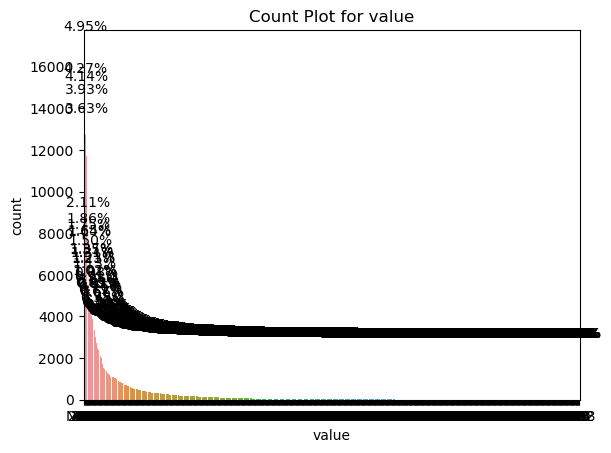

In [216]:
# we have 3 coloumns that are basicly thesame diag_1, diag_2, and diag_3: we decided to turn it to unite and turn it to categorical featurs 
diag = df_categorical.reset_index().melt(id_vars='encounter_id', value_vars=['diag_1','diag_2','diag_3']).drop(columns='variable')
# diag.value = diag.apply(lambda row: change_value(row.value), axis=1)
plot_categorical_with_percent(diag, 'value')

ICD-9-CM stands for the International Classification of Diseases, Ninth Revision, Clinical Modification. It is a system of codes used for classifying diseases and health conditions. The ICD-9-CM was used in the United States until it was replaced by ICD-10-CM on October 1, 2015. Despite its replacement, ICD-9-CM codes may still be found in historical medical records.

Each ICD-9-CM code is alphanumeric and consists of up to five digits. Here's a breakdown of how to read the codes:

First Digit (Numeric): The first digit represents the category of the disease or condition.

Second and Third Digits (Numeric): These digits further specify the cause, location, severity, and type of the condition within the category.

Fourth and Fifth Digits (Alphanumeric): These digits provide additional detail, such as etiology, anatomical site, or a specific condition.

For example, consider the ICD-9-CM code 401.9:

401: This is the category code for hypertensive heart disease.
.9: These digits provide additional specificity. In this case, ".9" indicates that the code is unspecified, meaning it does not provide further detail about the type or severity of hypertensive heart disease.
In the ICD-9-CM coding system, the first digit of a code represents a broad category or major classification of diseases or conditions. The first digit is numeric, and it falls into one of the following general categories:

1. 001–139: Infectious and Parasitic Disease2. s 140–239: Neoplasms (Tumor3. s) 240–279: Endocrine, Nutritional, and Metabolic Diseases, and Immunity Disord4. ers 280–289: Diseases of the Blood and Blood-Forming Or5. gans 290–319: Mental Diso6. rders 320–389: Diseases of the Nervous System and Sense 7. Organs 390–459: Diseases of the Circulatory8. System 460–519: Diseases of the Respirator9. y System 520–579: Diseases of the Digesti10. ve System 580–629: Diseases of the Genitourin11. ary System 630–679: Complications of Pregnancy, Childbirth, and the12. Puerperium 680–709: Diseases of the Skin and Subcuta13. neous Tissue 710–739: Diseases of the Musculoskeletal System and Conn14. ective Tissue 740–759: Congen15. ital Anomalies 760–779: Certain Conditions Originating in the P16. erinatal Period 780–799: Symptoms, Signs, and Ill-De17. fined Conditions 800–999: Inj18. uoisoning E800–E999: Supplementary Classification of External Causes of In19. V: codes are used for factors influencing health status and contact with health services. These codes cover a broad range of circumstances that may not be classified as diseases but are relevant to healthcare encounters. heth servicesjury and Poisoning

if we are looking at the unique values we are seeing a lot of variation, dou to unique case in digits 4 and 5 in the code, lets change then we will unite al desises that are in the same catagory it to the first three digits only. we will take only diagnostics that are in 2.5 percent or more in the cases and we will remove '250' becuse all pationt are diabitic

<Axes: title={'center': 'Count Plot for value'}, xlabel='value', ylabel='count'>

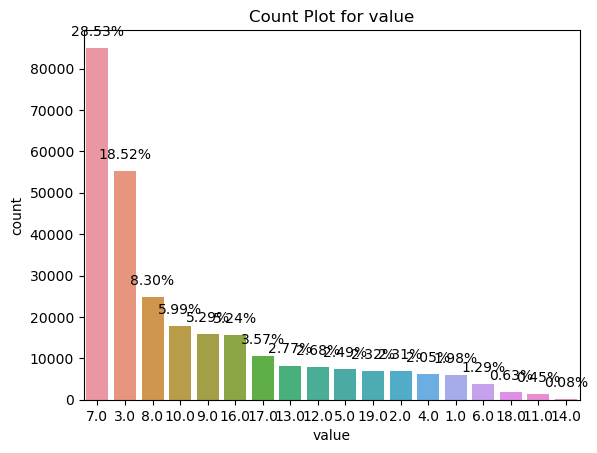

In [218]:
# lokking at the diag data we find two probloms
# 1. high number of fetuers,
# 2. uneven number of diag between patiants
# here we unite the diag based on the ICD-9-CM coding system into groups
# *each patiant can have more then one option

# df_categorical.reset_index()
# daig = df_categorical.reset_index().melt(id_vars='encounter_id', value_vars=['diag_1','diag_2','diag_3']).drop(columns='variable')




def change_value(value): 
    diag_dict = {1: range(0,140), 2: range(140, 240), 3: range(240,280), 4: range(280,290), 5:range(290,320),
            6: range(320, 390), 7: range(390,460), 8: range(460, 520), 9: range(520, 580), 10: range(580,630),
            11: range(630, 680), 12: range(680,710), 13: range(710, 740), 14: range(740, 760), 15: range(760, 780),
            16: range(780, 800), 17: range(800, 1000), 18: 'E', 19:'V'}

    diag_dict = {value: key for key, values_list in diag_dict.items() for value in values_list}

    value = str(value).split('.')[0]
    try:
        return diag_dict[int(value)]
    except ValueError:
        try:
            return diag_dict[str(value[0]).upper()]
        except KeyError:
            return np.nan


diag = df_categorical.reset_index().melt(id_vars='encounter_id', value_vars=['diag_1','diag_2','diag_3']).drop(columns='variable')
diag.value = diag.apply(lambda row: change_value(row.value), axis=1)
plot_categorical_with_percent(diag, 'value')
# diag = pd.get_dummies(diag, columns=['value'], prefix='daig_').groupby('encounter_id').sum()

# diag=diag>0
# diag.astype(int).sum(axis=0)/len(diag) *100

# df_with_diag = pd.concat([df_witout_bed_columns.set_index('encounter_id'), diag], axis=1)
# df_with_diag.drop(columns=['diag_1','diag_2','diag_3'], inplace=True)


In [219]:
# Assuming 'change_value' is a function that transforms the values based on the type
def change_value(value): 
    diag_dict = {1: range(0,140), 2: range(140, 240), 3: range(240,280), 4: range(280,290), 5:range(290,320),
            6: range(320, 390), 7: range(390,460), 8: range(460, 520), 9: range(520, 580), 10: range(580,630),
            11: range(630, 680), 12: range(680,710), 13: range(710, 740), 14: range(740, 760), 15: range(760, 780),
            16: range(780, 800), 17: range(800, 1000), 18: 'E', 19:'V'}

    diag_dict = {value: key for key, values_list in diag_dict.items() for value in values_list}

    value = str(value).split('.')[0]
    try:
        return diag_dict[int(value)]
    except ValueError:
        try:
            return diag_dict[str(value[0]).upper()]
        except KeyError:
            return np.nan



def change_diag_to_type(row):
    diag_1 = change_value(row['diag_1'])
    diag_2 = change_value(row['diag_2'])
    diag_3 = change_value(row['diag_3'])  
    return pd.Series([diag_1, diag_2, diag_3], index=['diag_1', 'diag_2', 'diag_3'])

# Apply the function to each row and create new columns
df_categorical[['diag_1', 'diag_2', 'diag_3']] = df_categorical.apply(change_diag_to_type, axis=1)


<Axes: title={'center': 'Count Plot for diag_1'}, xlabel='diag_1', ylabel='count'>

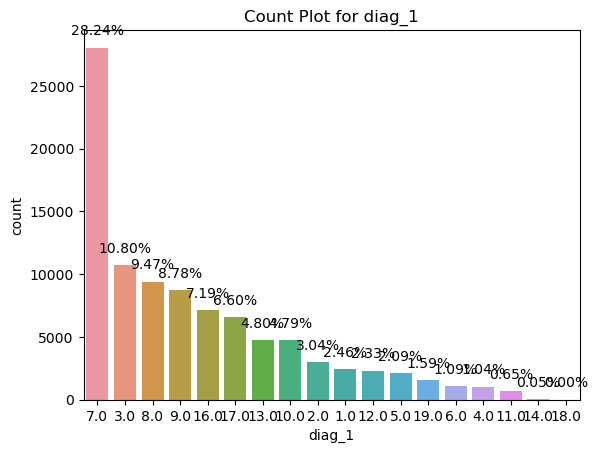

In [220]:
plot_categorical_with_percent(df_categorical, 'diag_1')

<Axes: title={'center': 'Count Plot for diag_2'}, xlabel='diag_2', ylabel='count'>

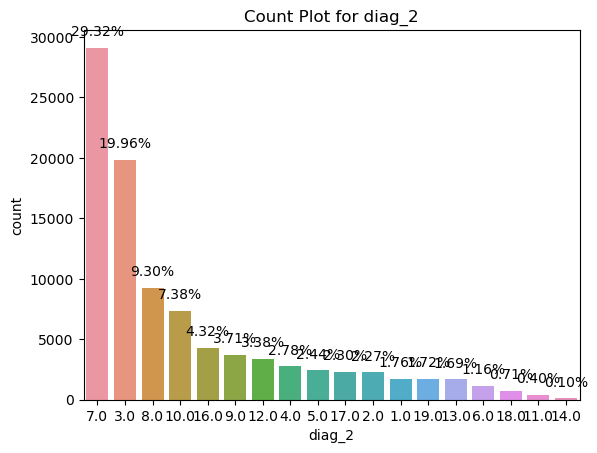

In [221]:
plot_categorical_with_percent(df_categorical, 'diag_2')

<Axes: title={'center': 'Count Plot for diag_3'}, xlabel='diag_3', ylabel='count'>

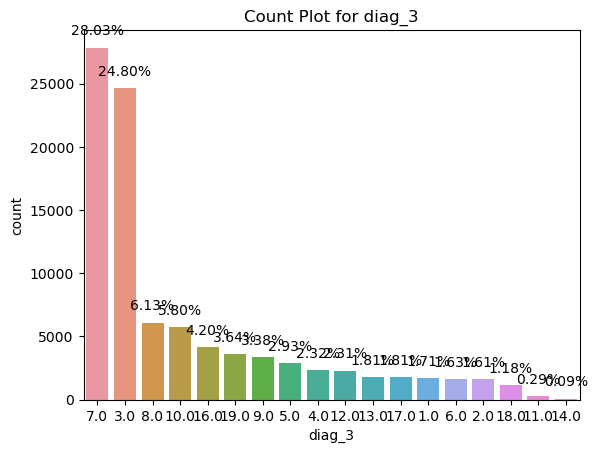

In [222]:
plot_categorical_with_percent(df_categorical, 'diag_3')

In [223]:
df_categorical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99340 entries, 2278392 to 443867222
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   race                 99340 non-null  object 
 1   gender               99340 non-null  object 
 2   age                  99340 non-null  object 
 3   admission            99340 non-null  object 
 4   discharge            99340 non-null  object 
 5   admission_source_id  99340 non-null  object 
 6   medical_specialty    99340 non-null  object 
 7   diag_1               94399 non-null  float64
 8   diag_2               94071 non-null  float64
 9   diag_3               93049 non-null  float64
 10  max_glu_serum        99340 non-null  object 
 11  metformin            99340 non-null  object 
 12  glimepiride          99340 non-null  object 
 13  glipizide            99340 non-null  object 
 14  glyburide            99340 non-null  object 
 15  pioglitazone         99340

In [225]:
df_categorical = df_categorical.astype('category')

In [226]:
df_categorical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99340 entries, 2278392 to 443867222
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   race                 99340 non-null  category
 1   gender               99340 non-null  category
 2   age                  99340 non-null  category
 3   admission            99340 non-null  category
 4   discharge            99340 non-null  category
 5   admission_source_id  99340 non-null  category
 6   medical_specialty    99340 non-null  category
 7   diag_1               94399 non-null  category
 8   diag_2               94071 non-null  category
 9   diag_3               93049 non-null  category
 10  max_glu_serum        99340 non-null  category
 11  metformin            99340 non-null  category
 12  glimepiride          99340 non-null  category
 13  glipizide            99340 non-null  category
 14  glyburide            99340 non-null  category
 15  pioglitaz

In [228]:
# final df!
result_df = pd.concat([df_categorical, df[numerical_columns]], axis=1)
result_df.info()

In [55]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99340 entries, 2278392 to 443867222
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   race                 99340 non-null  object
 1   gender               99340 non-null  object
 2   age                  99340 non-null  object
 3   admission            99340 non-null  object
 4   discharge            99340 non-null  object
 5   admission_source_id  99340 non-null  object
 6   medical_specialty    99340 non-null  object
 7   diag_1               99340 non-null  object
 8   diag_2               99340 non-null  object
 9   diag_3               99340 non-null  object
 10  max_glu_serum        99340 non-null  object
 11  metformin            99340 non-null  object
 12  glimepiride          99340 non-null  object
 13  glipizide            99340 non-null  object
 14  glyburide            99340 non-null  object
 15  pioglitazone         99340 non-null  object

# 6. Split test and validation 

In [197]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(result_df, test_size=0.2, random_state=42, stratify=result_df['readmitted'])

<Axes: title={'center': 'Count Plot for readmitted'}, xlabel='readmitted', ylabel='count'>

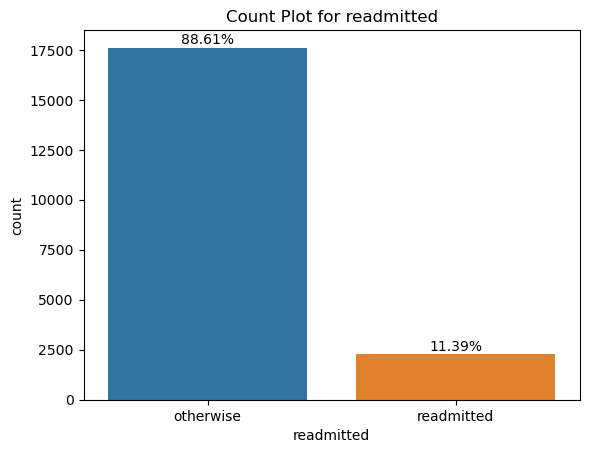

In [198]:
plot_categorical_with_percent(test_set, column='readmitted')

<Axes: title={'center': 'Count Plot for readmitted'}, xlabel='readmitted', ylabel='count'>

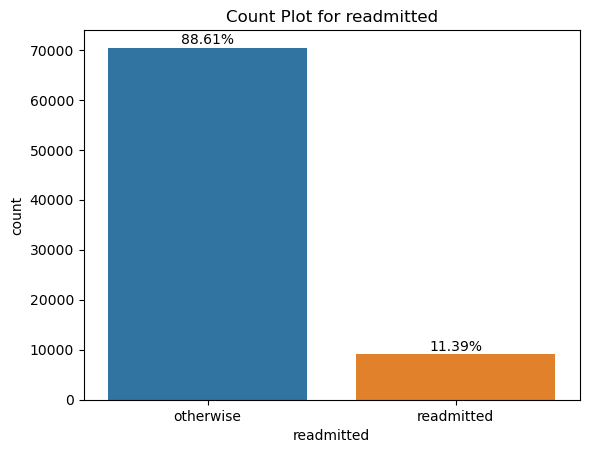

In [199]:
plot_categorical_with_percent(train_set, column='readmitted')

In [177]:
train = train_set.drop("readmitted", axis=1) # drop labels for training set
train_labels = train_set["readmitted"].copy()

In [200]:
cat_columns = df_categorical.drop(columns=['readmitted']).keys()

In [201]:
df_categorical = df_categorical.drop(columns=['readmitted'])

In [202]:
df_categorical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99340 entries, 2278392 to 443867222
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   race                 99340 non-null  category
 1   gender               99340 non-null  category
 2   age                  99340 non-null  category
 3   admission            99340 non-null  category
 4   discharge            99340 non-null  category
 5   admission_source_id  99340 non-null  category
 6   medical_specialty    99340 non-null  category
 7   diag_1               99340 non-null  category
 8   diag_2               99340 non-null  category
 9   diag_3               99340 non-null  category
 10  max_glu_serum        99340 non-null  category
 11  metformin            99340 non-null  category
 12  glimepiride          99340 non-null  category
 13  glipizide            99340 non-null  category
 14  glyburide            99340 non-null  category
 15  pioglitaz

In [203]:
from sklearn.preprocessing import OrdinalEncoder
df_categorical = df_categorical.astype(str)
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(df_categorical)
housing_cat_encoded[:10]

array([[ 1.,  0.,  1.,  2.,  1.,  0.,  7., 11., 18., 18.,  2.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  0.,  2.],
       [ 1.,  0.,  1.,  1.,  0., 14.,  6., 11., 11., 11.,  2.,  1.,  1.,
         1.,  1.,  1.,  1.,  3.,  1.,  2.],
       [ 0.,  0.,  1.,  1.,  0., 14.,  6.,  2., 11.,  9.,  2.,  1.,  1.,
         2.,  1.,  1.,  1.,  1.,  1.,  2.],
       [ 1.,  1.,  0.,  1.,  0., 14.,  6.,  0., 11., 15.,  2.,  1.,  1.,
         1.,  1.,  1.,  1.,  3.,  1.,  2.],
       [ 1.,  1.,  0.,  1.,  0., 14.,  6., 10., 10., 11.,  2.,  1.,  1.,
         2.,  1.,  1.,  1.,  2.,  1.,  2.],
       [ 1.,  1.,  0.,  1.,  0.,  6.,  6., 15., 15., 11.,  2.,  1.,  1.,
         1.,  1.,  1.,  1.,  2.,  1.,  2.],
       [ 1.,  1.,  2.,  0.,  0.,  6.,  6., 15., 15.,  9.,  2.,  2.,  2.,
         1.,  1.,  1.,  1.,  2.,  1.,  2.],
       [ 1.,  1.,  2.,  1.,  0., 14.,  6., 15., 16., 11.,  2.,  1.,  1.,
         1.,  2.,  1.,  1.,  1.,  1.,  2.],
       [ 1.,  0.,  2.,  1.,  0., 11.,  6., 15., 15.,  0.,  2.,  

In [204]:
housing_cat_encoded.shape

(99340, 20)

In [205]:
ordinal_encoder.categories_

[array(['AfricanAmerican', 'Caucasian', 'missing', 'other'], dtype=object),
 array(['Female', 'Male'], dtype=object),
 array(['30<60', '<30', '>60'], dtype=object),
 array(['clinic_referral', 'high_prayority', 'other'], dtype=object),
 array(['home', 'other'], dtype=object),
 array(['1', '10', '11', '13', '14', '17', '2', '20', '22', '25', '3', '4',
        '5', '6', '7', '8', '9'], dtype=object),
 array(['Cardiology', 'Emergency/Trauma', 'Family/GeneralPractice',
        'InternalMedicine', 'Nephrology', 'Surgery-General', 'missing',
        'other'], dtype=object),
 array(['1', '10', '11', '12', '13', '14', '16', '17', '18', '19', '2',
        '3', '4', '5', '6', '7', '8', '9', 'missing'], dtype=object),
 array(['1', '10', '11', '12', '13', '14', '16', '17', '18', '19', '2',
        '3', '4', '5', '6', '7', '8', '9', 'missing'], dtype=object),
 array(['1', '10', '11', '12', '13', '14', '16', '17', '18', '19', '2',
        '3', '4', '5', '6', '7', '8', '9', 'missing'], dtype=object),


In [206]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()

df_categorical_1hot = cat_encoder.fit_transform(df_categorical)
df_categorical_1hot

<99340x134 sparse matrix of type '<class 'numpy.float64'>'
	with 1986800 stored elements in Compressed Sparse Row format>

In [210]:
df_categorical_1hot.toarray().shape

(99340, 134)

In [212]:
cat_encoder = OneHotEncoder(sparse_output=False)
housing_cat_1hot = cat_encoder.fit_transform(df_categorical)
housing_cat_1hot

array([[0., 1., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 1., 0.]])

In [213]:
cat_encoder.categories_

[array(['AfricanAmerican', 'Caucasian', 'missing', 'other'], dtype=object),
 array(['Female', 'Male'], dtype=object),
 array(['30<60', '<30', '>60'], dtype=object),
 array(['clinic_referral', 'high_prayority', 'other'], dtype=object),
 array(['home', 'other'], dtype=object),
 array(['1', '10', '11', '13', '14', '17', '2', '20', '22', '25', '3', '4',
        '5', '6', '7', '8', '9'], dtype=object),
 array(['Cardiology', 'Emergency/Trauma', 'Family/GeneralPractice',
        'InternalMedicine', 'Nephrology', 'Surgery-General', 'missing',
        'other'], dtype=object),
 array(['1', '10', '11', '12', '13', '14', '16', '17', '18', '19', '2',
        '3', '4', '5', '6', '7', '8', '9', 'missing'], dtype=object),
 array(['1', '10', '11', '12', '13', '14', '16', '17', '18', '19', '2',
        '3', '4', '5', '6', '7', '8', '9', 'missing'], dtype=object),
 array(['1', '10', '11', '12', '13', '14', '16', '17', '18', '19', '2',
        '3', '4', '5', '6', '7', '8', '9', 'missing'], dtype=object),


In [215]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99340 entries, 2278392 to 443867222
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   race                 99340 non-null  category
 1   gender               99340 non-null  category
 2   age                  99340 non-null  category
 3   admission            99340 non-null  category
 4   discharge            99340 non-null  category
 5   admission_source_id  99340 non-null  category
 6   medical_specialty    99340 non-null  category
 7   diag_1               99340 non-null  category
 8   diag_2               99340 non-null  category
 9   diag_3               99340 non-null  category
 10  max_glu_serum        99340 non-null  category
 11  metformin            99340 non-null  category
 12  glimepiride          99340 non-null  category
 13  glipizide            99340 non-null  category
 14  glyburide            99340 non-null  category
 15  pioglitaz

In [219]:
from sklearn.compose import ColumnTransformer

cat_attribs = df_categorical.drop(columns=['readmitted']).keys()

full_pipeline = ColumnTransformer([
        ("cat", OneHotEncoder(sparse_output=False), cat_attribs),
    ])

result_df = full_pipeline.fit_transform(result_df)

In [221]:
result_df

<99340x134 sparse matrix of type '<class 'numpy.float64'>'
	with 1986800 stored elements in Compressed Sparse Row format>

In [231]:
labels = df['readmitted']

In [225]:
result_df.shape

(99340, 134)

In [232]:
os.getcwd()

'C:\\Users\\dekel\\Desktop\\Tidy Data-20240116\\ml-2024'

In [235]:
import data_transformers as dt

In [237]:
dt

<module 'data_transformers' from 'C:\\Users\\dekel\\Desktop\\Tidy Data-20240116\\ml-2024\\data_transformers.py'>

In [236]:
result_df

<99340x134 sparse matrix of type '<class 'numpy.float64'>'
	with 1986800 stored elements in Compressed Sparse Row format>